# Monitoring Snow and Ice in Iceland <img src="images/Iceland.png" alt="Iceland"  style="float: right; width: 25%; margin: auto;"> 

## Testing the New EOPF Data Format Zarr


by Robin Gummels, Humam Hikmat, Justin Krumböhmer, and Kian Jay Lenert



# Table of contents
1. Introduction
2. Creating Seeds
3. Zarr Optimize Algorithm
4. Sentinel Native Algorithm
5. Benchmarking
6. Conclusion

## 1 Introduction

Iceland’s glaciers are shrinking, with seasonal melt–freeze cycles superimposed on a persistent long‑term decline (see: [Icelandic glacier loss - AntarcticGlaciers.org](https://www.antarcticglaciers.org/glaciers-and-climate/glacier-recession/icelandic-glacier-loss/) and [A Revised Snow Cover Algorithm to Improve Discrimination between Snow and Clouds: A Case Study in Gran Paradiso National Park](https://www.mdpi.com/2072-4292/13/10/1957)). To monitor these changes at scale, we need methods that minimize data movement while preserving scientific fidelity. 

This poses a use case for testing the new EOPF Zarr format. Zarr is a data format developed to store earth observation data and make accessing and using it more efficient and scalable. More precisely, it stores the data in chunked, compressed arrays and is designed for cloud storage and cloud-native analyses.

To find out what advantages or challenges it holds, in our project, we carried out an analysis of Iceland's glacial areas with Sentinel-2 data in EOPF Zarr format using two different algorithms: the first approach is making use of the data's chunked structure, iteratively processing chunks of e.g. 10x10km, while the second algorithm processes a whole 110x110km Sentinel-2 scene. Like this, we can evaluate wether or not or to what extent such a spatio-temporal analysis can profit from the properties of Zarr data.

At the end of this notebook, we compare the results and benchmarking results of both algorithms and give our review on the Zarr format.

## 2 Creating Seeds

The Zarr-Optimized Algorithm needs the locations of glaciers as starting points.  

Therefore, we predefined seeds using [Icelands Corine land cover data](https://www.natt.is/en/resources/open-data/data-download) to locate glacial areas. Setting a centroid in each area that was classified as glacier by CLC results in a dataset of 203 points. Setting one point in the center of each region of connected glaciers or glaciers located close to each other (= within 5km distance) yields a dataset of 21 points.

This procedure was done as precomputation in QGIS.

The seeds are distributed across Iceland as follows:

In [19]:
import folium
import geopandas as gpd
seeds_file_21 = "./data/Iceland_Seeds_21.geojson"
seeds_file_203 = "./data/Iceland_Seeds_203.geojson"
df_seeds_21 = gpd.read_file(seeds_file_21)
if df_seeds_21.crs is None:
    df_seeds_21 = df_seeds_21.set_crs("EPSG:4326")
else:
    df_seeds_21 = df_seeds_21.to_crs("EPSG:4326")

df_seeds_203 = gpd.read_file(seeds_file_203)
if df_seeds_203.crs is None:
    df_seeds_203 = df_seeds_203.set_crs("EPSG:4326")
else:
    df_seeds_203 = df_seeds_203.to_crs("EPSG:4326")

m = folium.Map(zoom_start=10)

folium.GeoJson(
    df_seeds_203,
    marker=folium.CircleMarker(
        radius=1,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.8
    )
).add_to(m)

folium.GeoJson(
    df_seeds_21,
    marker=folium.CircleMarker(
        radius=1,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.8
    )
).add_to(m)

minx, miny, maxx, maxy = df_seeds_203.total_bounds
bounds = [[miny, minx], [maxy, maxx]]
m.fit_bounds(bounds)
m

## 3 Zarr Optimize Algorithm

### 3.1 Description

The idea of this algorithm is to exploit the chunking of the cloud-native Zarr format in order to load only those parts of the Sentinel-2 scenes that are actually needed.

The Algorithm could be devided in the following steps:
1. **Load Seeds**: We load glacier seed points via a GeoJSON.
2. **Create Grid**: Then we create a 10 km × 10 km grid (EPSG:5325) that covers the whole of Iceland and mark every grid cell as a *candidate* that contains at least one seed point.  
3. **Query STAC**: For each *candidate* 10 km × 10 km cell, we query the Sentinel-2 L2A collection via [STAC](https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items) to find all scenes in the given time period whose footprint intersects the cell.  
4. **Load Zarr Data**: For each scene, we load only the relevant data chunks from the Zarr store:
   - Transform cell bounds from ISN2004 to the scene's UTM zone
   - Extract B03 (Green, 10m) and B11 (SWIR1, 20m) bands
   - Apply Scene Classification Layer (SCL) quality mask to remove clouds, shadows, and water  
5. **Compute Median NDSI**: From all loaded scenes (across all tiles), we:
   - Resample B11 from 20m to 10m resolution
   - Calculate NDSI = (B03 - B11) / (B03 + B11) for each scene
   - Reproject all NDSI arrays to common ISN2004 grid (10m resolution)
   - Compute temporal median to reduce noise and cloud contamination.
   - Every pixel with NDSI ≥ 0.42 is classified as snow/ice.  
7. **Spatial Expansion**: If more than 30% of the pixels within a *candidate* cell are classified as snow/ice, all 4 neighboring cells (that have not yet been processed) are also marked as *candidate* cells.
8. **Iterate**: The algorithm repeats steps 3 to 7 until no additional *candidate* cells remain.

<figure>
<img src="images/iterativeProcess.png" alt="Iterative process visualization"  style="width: 30%; margin: auto;"> <figcaption>Visualization of the iterative tile processing</figcaption>
</figure>

The Juypter notebook tries to implement one step after the other and give the user an idea of how the algorithm works. Therefore most of the time, after an implementation of a step as a function, another Jupyter notebook cell follows with some kind of testing.

To use the script for production purposes, it is recommended to use raw-python script stored under `.\glacier_monitoring.py`. Be aware that the python script offers even more possible running-settings, like restricting the seeds to a given set of IDs or change the grid resolution. Here all the adjustments of the global variables can be made by using run parameters, e. g. `python glacier_monitoring.py --seeds data/Iceland_Seeds.geojson --fid 5 --output results`. 

### 3.2 Implementation

#### 3.2.1 Step 0: Imports and Configuration

Before running any part of the algorithm, it's necessary to install all needed libraries. We are also defining some global variables (like settings of the algorithm) here.

In [20]:
# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import box, Point
import pyproj
from pyproj import Transformer

# Data processing
import xarray as xr
import numpy as np
import pandas as pd
import dask.array
import rioxarray  # For CRS handling and reprojection
from rasterio.transform import from_bounds

# STAC API for Sentinel-2 data
from pystac_client import Client

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
from folium import plugins

# Global Configuration Variables
EPSG_ICELAND = 5325  # ISN2004 / Lambert 2004 (Iceland's national projection)
BOUNDING_BOX_ICELAND = [1400000, 100000, 2000000, 500000]  # [minx, miny, maxx, maxy] in ISN2004
GRID_SIZE = 10000  # Grid cell size: 10 km in meters
NDSI_THRESHOLD = 0.42  # Snow/ice classification threshold (NDSI >= 0.42)
SNOW_PERCENTAGE_THRESHOLD = 0.30  # Spatial expansion threshold (30% snow coverage)
STAC_URL = "https://stac.core.eopf.eodc.eu"  # EOPF STAC Catalog endpoint

# Time period configuration
DATE_START = "2025-07-01"  # Start date for Sentinel-2 data query (YYYY-MM-DD)
DATE_END = "2025-07-31"    # End date for Sentinel-2 data query (YYYY-MM-DD)

# For devoloping
MAX_ITERATIONS = 50  # Maximum number of iterations for the spatial expansion algorithm

ModuleNotFoundError: No module named 'rioxarray'

#### 3.2.2 Step 1: Load and Visualize Seeds

**Goal**: Load glacier seed points that mark known glacier locations across Iceland.

- Display statistics and create interactive map with satellite imagery background

**Input**: `data/Iceland_Seeds_203.geojson` (203 glacier seed points from CORINE Land Cover) - Transform to ISN2004 coordinate system if necessary

- Load seed points from GeoJSON file

**Output**: GeoDataFrame with seed points in EPSG:5325 (ISN2004)


In [ ]:
# Load seeds
seeds = gpd.read_file('data/Iceland_Seeds_203.geojson')

# Check CRS and transform to ISN2004 if necessary
print(f"Original CRS: {seeds.crs}")
if seeds.crs.to_epsg() != EPSG_ICELAND:
    seeds = seeds.to_crs(epsg=EPSG_ICELAND)
    print(f"Transformed to EPSG:{EPSG_ICELAND}")

# Overview of the seeds
print(f"\nNumber of seed points: {len(seeds)}")
print(f"\nFirst 3 seeds:")
print(seeds.head(3))

# Get bounds of the seeds
bounds = seeds.total_bounds
print(f"\nBounding box of seeds (EPSG:{EPSG_ICELAND}):")
print(f"   X: [{bounds[0]:.0f}, {bounds[2]:.0f}]")
print(f"   Y: [{bounds[1]:.0f}, {bounds[3]:.0f}]")

Original CRS: EPSG:5325


NameError: name 'EPSG_ICELAND' is not defined

To give you an idea of how our seeds look like, we can create a interactive visualization of seed points with folium:

In [ ]:
# Interactive visualization of the seeds with satellite imagery
seeds_wgs84 = seeds.to_crs(epsg=4326)  # WGS84 for web maps

# Calculate center of Iceland for map
center_lat = seeds_wgs84.geometry.y.mean()
center_lon = seeds_wgs84.geometry.x.mean()

# Create interactive map with satellite imagery
map_seeds = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles=None
)

# Add Esri World Imagery
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri World Imagery',
    name='Satellite Imagery',
    overlay=False,
    control=True
).add_to(map_seeds)

# Add seed points to map
for idx, row in seeds_wgs84.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.5,
        popup=f"Seed {idx}",
        tooltip="Glacier Seed"
    ).add_to(map_seeds)

# Add layer control
folium.LayerControl().add_to(map_seeds)

print(f"Step 1 completed: {len(seeds)} seeds loaded and visualized")
print("Interactive map created with satellite imagery background")

# Display map
map_seeds

Step 1 completed: 203 seeds loaded and visualized
Interactive map created with satellite imagery background


#### 3.2.3 Step 2: Create Grid and Mark Candidates

**Goal**: Create a regular grid covering Iceland and identify candidate cells for processing.

- Mark cells with seeds as initial candidates for processing

**Input**: Spatial join to identify which cells contain seed points

- `BOUNDING_BOX_ICELAND`: Extent of Iceland in ISN2004 coordinates- Generate regular grid covering Iceland's bounding box

- `GRID_SIZE`: Cell size (10,000 m = 10 km)

- Seeds from Step 1

**Output**: 

- GeoDataFrame with cells covering the given extent and an identifier if a cell is a candidate (contains a seed)

In [ ]:
def create_grid(bounds, grid_size):
    """
    Creates a regular grid with the given cell size and bounding box.
    
    Parameters:
    -----------
    bounds : tuple
        (xmin, ymin, xmax, ymax) in meters
    grid_size : int
        Size of a grid cell in meters
        
    Returns:
    --------
    gpd.GeoDataFrame with columns:
        - cell_id: Unique identifier for each cell
        - geometry: Polygon representing the cell boundary
    """
    xmin, ymin, xmax, ymax = bounds
    
    # Round the grid boundaries to multiples of grid_size
    xmin = np.floor(xmin / grid_size) * grid_size
    ymin = np.floor(ymin / grid_size) * grid_size
    xmax = np.ceil(xmax / grid_size) * grid_size
    ymax = np.ceil(ymax / grid_size) * grid_size
    
    # Create grid cells
    grid_cells = []
    grid_ids = []
    cell_id = 0
    
    y = ymin
    while y < ymax:
        x = xmin
        while x < xmax:
            # Create a square polygon for each grid cell
            cell = box(x, y, x + grid_size, y + grid_size)
            grid_cells.append(cell)
            grid_ids.append(cell_id)
            cell_id += 1
            x += grid_size
        y += grid_size
    
    # Create GeoDataFrame
    grid = gpd.GeoDataFrame({
        'cell_id': grid_ids,
        'geometry': grid_cells
    }, crs=f"EPSG:{EPSG_ICELAND}")
    
    return grid

# Create grid
grid = create_grid(BOUNDING_BOX_ICELAND, GRID_SIZE)

print(f"Grid created:")
print(f"Number of grid cells: {len(grid)}")
print(f"Cell size: {GRID_SIZE/1000} km × {GRID_SIZE/1000} km")

Grid created:
Number of grid cells: 2400
Cell size: 10.0 km × 10.0 km


Now we mark every cell which contains a seed as a candidate.

In [ ]:
# Mark grid cells with seeds as candidates
def mark_candidate_cells(grid, seeds):
    """
    Marks grid cells that contain at least one seed point as candidates for processing.
    
    Uses spatial join to identify which grid cells intersect with seed points.
    Only cells containing seeds are marked as initial candidates.
    
    Parameters:
    -----------
    grid : gpd.GeoDataFrame
        GeoDataFrame with grid cells (from create_grid)
    seeds : gpd.GeoDataFrame
        GeoDataFrame with seed points (glacier locations)
        
    Returns:
    --------
    gpd.GeoDataFrame with additional columns:
        - is_candidate: bool indicating if the cell contains at least one seed
        - seed_count: number of seeds contained in the cell
    """
    # Initialize all cells as non-candidates
    grid['is_candidate'] = False
    grid['seed_count'] = 0
    
    # Spatial join: which grid cells contain which seeds?
    joined = gpd.sjoin(grid, seeds, how='inner', predicate='contains')
    
    # Count seeds per grid cell (only for cells that contain seeds)
    if len(joined) > 0:
        candidate_counts = joined.groupby('cell_id').size()
        
        # Mark cells containing seeds as candidates
        grid.loc[grid['cell_id'].isin(candidate_counts.index), 'is_candidate'] = True
        grid.loc[grid['cell_id'].isin(candidate_counts.index), 'seed_count'] = \
            grid.loc[grid['cell_id'].isin(candidate_counts.index), 'cell_id'].map(candidate_counts)
    
    return grid

grid = mark_candidate_cells(grid, seeds)

# Statistics
n_candidates = grid['is_candidate'].sum()
print(f"\n Grid statistics:")
print(f"   Total grid cells: {len(grid)}")
print(f"   Candidate cells: {n_candidates}")
print(f"   Seeds per candidate (average): {grid[grid['is_candidate']]['seed_count'].mean():.1f}")


 Grid statistics:
   Total grid cells: 2400
   Candidate cells: 87
   Seeds per candidate (average): 2.3


We can again create an interactive visualization which displays the seeds, grid, candidate cells and a background satellite image:

In [ ]:
# Transform to WGS84 for web mapping (folium requires WGS84)
grid_wgs84 = grid.to_crs(epsg=4326)
candidates_wgs84 = grid_wgs84[grid_wgs84['is_candidate']]
non_candidates_wgs84 = grid_wgs84[~grid_wgs84['is_candidate']]
seeds_wgs84 = seeds.to_crs(epsg=4326)

# Calculate center for map
center_lat = seeds_wgs84.geometry.y.mean()
center_lon = seeds_wgs84.geometry.x.mean()

# Create interactive map with satellite imagery
map_grid = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles=None
)

# Add Esri World Imagery
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri World Imagery',
    name='Satellite Imagery',
    overlay=False,
    control=True
).add_to(map_grid)

# Add ALL grid cells
folium.GeoJson(
    non_candidates_wgs84,
    name='All Grid Cells',
    style_function=lambda x: {
        'fillColor': 'lightblue',
        'color': 'lightgray',
        'weight': 0.5,
        'fillOpacity': 0.1,
        'opacity': 0.4
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['cell_id'],
        aliases=['Cell ID:'],
        localize=True
    )
).add_to(map_grid)

# Add candidate cells
folium.GeoJson(
    candidates_wgs84[['cell_id', 'seed_count', 'geometry']],
    name='Candidate Cells',
    style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'darkblue',
        'weight': 2.5,
        'fillOpacity': 0.4,
        'opacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['cell_id', 'seed_count'],
        aliases=['Cell ID:', 'Seeds:'],
        localize=True
    ),
    popup=folium.GeoJsonPopup(
        fields=['cell_id', 'seed_count'],
        aliases=['Cell ID:', 'Number of Seeds:']
    )
).add_to(map_grid)

# Add seed points as feature group
seed_group = folium.FeatureGroup(name='Glacier Seeds')
for idx, row in seeds_wgs84.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.7,
        popup=f"<b>Seed {idx}</b>",
        tooltip="Glacier Seed"
    ).add_to(seed_group)

seed_group.add_to(map_grid)

# Add fullscreen button
plugins.Fullscreen().add_to(map_grid)

# Add layer control (allows toggling layers on/off)
folium.LayerControl(collapsed=False).add_to(map_grid)

print(f"Step 2 completed: Grid with {n_candidates} candidate cells created")
print(f"Interactive map created with {len(grid)} grid cells ({n_candidates} highlighted as candidates)")
print("Tip: Use the layer control in the top right to toggle layers on/off")

# Display map
map_grid

Step 2 completed: Grid with 87 candidate cells created
Interactive map created with 2400 grid cells (87 highlighted as candidates)
Tip: Use the layer control in the top right to toggle layers on/off


#### 3.2.4 Step 3: Query STAC Catalog

**Goal**: Find all Sentinel-2 L2A scenes that cover a candidate cell in the specified time period.

**Input**:
- Candidate cell (with geometry in ISN2004)
- Time period (date_start, date_end)
- `STAC_URL`: EOPF STAC Catalog endpoint

**Output**: List of STAC items (Sentinel-2 L2A scenes) with Zarr data URLs

**Process**:
- Transform cell bounds from ISN2004 to WGS84 (required for STAC API)
- Query EOPF catalog for all Sentinel-2 L2A scenes intersecting the cell
- Return all matching scenes (from all tiles)
- Filter by time period

In [ ]:
def query_stac_for_cell(cell, date_start, date_end, epsg_code=5325, stac_url=None, verbose=False):
    """
    Query EOPF STAC Catalog for Sentinel-2 L2A scenes covering a grid cell.
    
    This function searches for all Sentinel-2 L2A scenes that intersect with
    the given cell's geometry during the specified time period. It handles
    coordinate transformation from ISN2004 to WGS84 (required by STAC API).
    
    Parameters:
    -----------
    cell : pandas.Series or dict
        Cell with 'geometry' attribute (Shapely polygon in ISN2004)
    date_start : str
        Start date in format "YYYY-MM-DD"
    date_end : str
        End date in format "YYYY-MM-DD"
    epsg_code : int
        EPSG code of input cell geometry (default: 5325 for ISN2004)
    stac_url : str, optional
        STAC catalog URL (default: uses global STAC_URL variable)
    verbose : bool
        If True, print progress information (default: False)
    
    Returns:
    --------
    list : List of STAC items (pystac.Item objects) with Zarr data URLs
    """
    
    # Use global STAC_URL if not provided
    if stac_url is None:
        stac_url = STAC_URL
    
    # Transform cell bounds from ISN2004 to WGS84 (required by STAC API)
    cell_gdf = gpd.GeoDataFrame([cell], crs=f"EPSG:{epsg_code}")
    cell_wgs84 = cell_gdf.to_crs(epsg=4326)  # WGS84 for STAC API
    bbox_wgs84 = cell_wgs84.total_bounds  # (minx, miny, maxx, maxy)
    
    if verbose:
        print(f"Querying STAC catalog for cell ID: {cell.get('cell_id', 'unknown')}")
        print(f"  Time period: {date_start} to {date_end}")
        print(f"  Bounding box (WGS84): [{bbox_wgs84[0]:.4f}, {bbox_wgs84[1]:.4f}, {bbox_wgs84[2]:.4f}, {bbox_wgs84[3]:.4f}]")
    
    # Connect to EOPF STAC Catalog
    catalog = Client.open(stac_url)
    
    # Search for Sentinel-2 L2A scenes that intersect the cell
    # Note: No filtering by tile ID - we accept scenes from ALL tiles
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox_wgs84,
        datetime=[date_start, date_end]
    )
    
    # Collect results
    items = list(search.items())
    
    if verbose:
        print(f"  -> Found {len(items)} scenes") 
    return items

Beginning from Step 3, the algorithm is an iterative process, which will process each (candidate) cell on it's own. Therefore, after each implementation of a step as a reusable function, we will choose for educational purposes one test-cell and we will try to show the single processing steps.

In the following we pick one test-cell with
```{python}
test_cell = grid[grid['cell_id'] == 988].iloc[0]
```
If you wan't to try it out with any other cell, you need to change the `cell_id`. You can find the `cell_id`'s by clicking on a cell in the interactive visualization of the Grid in Step 2.

In [ ]:
# Select first candidate cell for testing
# test_cell = grid[grid['is_candidate']].iloc[5]
test_cell = grid[grid['cell_id'] == 330].iloc[0]

print(f"\nTest candidate cell:")
print(f"  Cell ID: {test_cell['cell_id']}")
print(f"  Seeds: {test_cell['seed_count']}")

# Get cell bounds for display
cell_bounds = test_cell.geometry.bounds  # (minx, miny, maxx, maxy)
print(f"  Bounds (ISN2004): X=[{cell_bounds[0]:.0f}, {cell_bounds[2]:.0f}], Y=[{cell_bounds[1]:.0f}, {cell_bounds[3]:.0f}]")

print(f"\nTime period: {DATE_START} to {DATE_END}\n")

# Execute Step 3: Query STAC catalog using global date variables
items = query_stac_for_cell(
    cell=test_cell,
    date_start=DATE_START,
    date_end=DATE_END,
    epsg_code=EPSG_ICELAND,
    verbose=True
)

print(f"Result: {len(items)} Sentinel-2 L2A scenes found")

if len(items) > 0:
    print(f"\nFirst scene details:")
    first_item = items[0]
    print(f"  ID: {first_item.id}")
    print(f"  Date: {first_item.datetime}")
    print(f"  Cloud cover: {first_item.properties.get('eo:cloud_cover', 'N/A')}%")
    print(f"  EPSG: {first_item.properties.get('proj:epsg', 'N/A')}")
else:
    print("\nWarning: No scenes found. Consider adjusting the time period.")


Test candidate cell:
  Cell ID: 330
  Seeds: 0
  Bounds (ISN2004): X=[1700000, 1710000], Y=[150000, 160000]

Time period: 2025-07-01 to 2025-07-31

Querying STAC catalog for cell ID: 330
  Time period: 2025-07-01 to 2025-07-31
  Bounding box (WGS84): [-19.0000, 63.6544, -18.7975, 63.7442]
  -> Found 12 scenes
Result: 12 Sentinel-2 L2A scenes found

First scene details:
  ID: S2C_MSIL2A_20250729T125321_N0511_R138_T27VWL_20250729T153911
  Date: 2025-07-29 12:53:21.025000+00:00
  Cloud cover: 99.898237%
  EPSG: N/A


#### 3.2.5 Step 4: Load Zarr Data

**Goal**: Load only the necessary data chunks from Sentinel-2 L2A Zarr stores for a specific cell.

**Input**:
- Zarr URL from STAC item
- Cell bounds in ISN2004 (EPSG:5325)
- Use lazy loading (Dask) for memory efficiency
- A boolean whether the bands `b02` and `bo4` should be also extracted for rgb-visualization purposes.

**Output**: Dictionary containing:

- `b03`: Green band (10m resolution) and `b11`: SWIR1 band (20m resolution) as lazy Dask array with quality mask applied

- Optional: `b02` blue band and `b04` red band (10m resolution) also as lazy Dask array with quality mask applied

- `valid_mask`: Boolean mask excluding clouds, shadows, water

- `metadata`: Scene metadata (EPSG code, acquisition time)

In [ ]:
def load_zarr_data_for_cell(zarr_url, cell_bounds_isn2004, cell_epsg_isn2004=5325, include_rgb=False):
    """
    Load and extract Zarr data for a specific cell using ESA best practices.
    
    Parameters:
    -----------
    zarr_url : str
        URL to the EOPF Sentinel-2 L2A Zarr store
    cell_bounds_isn2004 : tuple
        Cell bounds in ISN2004 coordinates (minx, miny, maxx, maxy)
    cell_epsg_isn2004 : int
        EPSG code of input coordinates (default 5325 for Iceland ISN2004)
    include_rgb : bool
        If True, also extract the additional RGB bands (B02, B04), which are not needed for NDSI, at 10m resolution
    
    Returns:
    --------
    dict or None : Dictionary containing:
        - 'b02': Blue band (10m resolution) as xr.DataArray or None
        - 'b03': Green band (10m resolution) as xr.DataArray
        - 'b04': Red band (10m resolution) as xr.DataArray or None
        - 'b11': SWIR1 band (20m resolution) as xr.DataArray
        - 'valid_mask': Quality mask (20m resolution)
        - 'metadata': STAC discovery metadata
    """
    
    try:
        # Open Zarr store as DataTree (ESA recommended approach)
        dt = xr.open_datatree(zarr_url, engine='zarr', chunks={})
        
        # Extract metadata
        metadata = dt.attrs.get('stac_discovery', {})
        product_epsg = metadata.get('properties', {}).get('proj:epsg')
        
        # Transform coordinates from ISN2004 to product UTM zone
        if product_epsg != cell_epsg_isn2004:
            transformer = Transformer.from_crs(cell_epsg_isn2004, product_epsg, always_xy=True)
            minx_in, miny_in, maxx_in, maxy_in = cell_bounds_isn2004
            (minx_utm, miny_utm) = transformer.transform(minx_in, miny_in)
            (maxx_utm, maxy_utm) = transformer.transform(maxx_in, maxy_in)
            minx_utm, maxx_utm = min(minx_utm, maxx_utm), max(minx_utm, maxx_utm)
            miny_utm, maxy_utm = min(miny_utm, maxy_utm), max(miny_utm, maxy_utm)
        else:
            minx_utm, miny_utm, maxx_utm, maxy_utm = cell_bounds_isn2004
        
        # Load bands and quality mask
        b03 = dt.measurements.reflectance.r10m.b03
        b11 = dt.measurements.reflectance.r20m.b11
        scl = dt.conditions.mask.l2a_classification.r20m.scl
        
        if include_rgb:
            # Load additional RGB bands at 10m resolution
            b02 = dt.measurements.reflectance.r10m.b02
            b04 = dt.measurements.reflectance.r10m.b04
        
        # Create quality mask (exclude invalid pixels)
        # SCL values: 0=NoData, 1=Saturated, 3=CloudShadow, 6=Water, 7=Unclassified 8=Cloud medium probablity 9=Cloud high probablity 10=Thin cirrus
        valid_mask = ~scl.isin([0, 1, 6, 7, 8, 9])
        
        # Clip using coordinate filtering
        x_mask_b03 = (b03.x >= minx_utm) & (b03.x <= maxx_utm)
        y_mask_b03 = (b03.y >= miny_utm) & (b03.y <= maxy_utm)
        b03_clipped = b03.sel(x=b03.x[x_mask_b03], y=b03.y[y_mask_b03])
        if include_rgb:
            b02_clipped = b02.sel(x=b03.x[x_mask_b03], y=b03.y[y_mask_b03])
            b04_clipped = b04.sel(x=b03.x[x_mask_b03], y=b03.y[y_mask_b03])
        
        x_mask_b11 = (b11.x >= minx_utm) & (b11.x <= maxx_utm)
        y_mask_b11 = (b11.y >= miny_utm) & (b11.y <= maxy_utm)
        b11_clipped = b11.sel(x=b11.x[x_mask_b11], y=b11.y[y_mask_b11])
        
        x_mask_scl = (scl.x >= minx_utm) & (scl.x <= maxx_utm)
        y_mask_scl = (scl.y >= miny_utm) & (scl.y <= maxy_utm)
        valid_clipped = valid_mask.sel(x=scl.x[x_mask_scl], y=scl.y[y_mask_scl])
        
        # Resample quality mask to 10m grid
        # Cast to float to allow interpolation, then back to bool
        valid_mask_10m = valid_clipped.astype(float).interp(
            x=b03_clipped.x, y=b03_clipped.y, method='nearest'
        ).astype(bool)
        
        # Apply quality mask to all bands (10m and 20m)
        b03_clipped = b03_clipped.where(valid_mask_10m)
        b11_clipped = b11_clipped.where(valid_clipped)
        
        if include_rgb:
            b02_clipped = b02_clipped.where(valid_mask_10m)
            b04_clipped = b04_clipped.where(valid_mask_10m)
        
        if b03_clipped.size == 0 or b11_clipped.size == 0:
            return None
        
        return {
            'b02': b02_clipped if include_rgb else None,
            'b03': b03_clipped,
            'b04': b04_clipped if include_rgb else None,
            'b11': b11_clipped,
            'valid_mask': valid_clipped,
            'valid_mask_10m': valid_mask_10m,
            'metadata': metadata
        }
    except Exception as e:
        print(f"  Error loading {zarr_url.split('/')[-1]}: {e}")
        return None

Here, no example for the `test_cell` is provided. You will find an example in Step 5, which combines the steps 4 and 5.

#### 3.2.6 Step 5: Compute Median NDSI Composite

**Goal**: Calculate a cloud-free median NDSI composite from multiple scenes.

**Input**:
- STAC items (list of Sentinel-2 scenes)
- Cell bounds in ISN2004
- `NDSI_THRESHOLD`: Classification threshold (0.42)
- `max_scenes`: Maximum number of scenes to process

**Output**: Dictionary containing:
- `ndsi_median`: Median NDSI array (1000×1000 pixels at 10m resolution)
- `snow_mask`: Boolean mask where NDSI ≥ threshold
- `snow_percentage`: Percentage of pixels classified as snow/ice
- `scene_count`: Number of scenes successfully processed
- `ndsi_stats`: Min, max, mean NDSI values

**Process**:
1. **Load scenes**: For each scene, call `load_zarr_data_for_cell()`
2. **Resample B11**: Interpolate B11 from 20m to 10m to match B03 resolution
3. **Calculate NDSI**: NDSI = (B03 - B11) / (B03 + B11 + ε) for each scene
4. **Reproject to common grid**: Transform each NDSI array from its UTM zone to ISN2004
   - This ensures all scenes (from different tiles) have the same grid alignment
   - Target: 10m pixel resolution in ISN2004 coordinates
5. **Stack and compute median**: Combine all reprojected NDSI arrays along time dimension to remove noise
   - Automatic NaN skipping removes cloud-affected pixels
   - Result is NaN only if all scenes have NaN at that location
6. **Classify snow**: Apply threshold (NDSI ≥ 0.42) to identify snow/ice pixels

In [ ]:
def compute_median_ndsi_for_cell(stac_items, cell_bounds, epsg_code=5325, max_scenes=10):
    """
    Compute median NDSI composite for a cell from multiple Sentinel-2 scenes.
    Uses ALL available scenes from ALL tiles - each scene is individually transformed
    from ISN2004 to its specific UTM zone.
    
    Parameters:
    -----------
    stac_items : list
        List of STAC items (Sentinel-2 L2A scenes)
    cell_bounds : tuple
        Cell bounds in ISN2004 coordinates (minx, miny, maxx, maxy)
    epsg_code : int
        EPSG code of input coordinates (default 5325 for Iceland)
    max_scenes : int
        Maximum number of scenes to process (default 10)
    
    Returns:
    --------
    dict or None : Dictionary containing:
        - 'ndsi_median': Median NDSI as xr.DataArray
        - 'snow_mask': Boolean mask where NDSI >= threshold
        - 'snow_percentage': Percentage of snow/ice pixels
        - 'scene_count': Number of scenes successfully loaded
    """
    
    print(f"\nProcessing up to {max_scenes} scenes from {len(stac_items)} available...")
    
    ndsi_list = []
    scenes_loaded = 0
    
    # Load and process each scene (from all tiles)
    # Each scene will be transformed individually from ISN2004 to its specific UTM zone
    for idx, item in enumerate(stac_items[:max_scenes]):
        zarr_url = item.assets["product"].href
        scene_id = item.id
        
        print(f"  [{idx+1}/{min(len(stac_items), max_scenes)}] {scene_id[:30]}...", end=" ")
        
        # Load Zarr data (handles coordinate transformation automatically)
        zarr_data = load_zarr_data_for_cell(zarr_url, cell_bounds, epsg_code)
        
        if zarr_data is None:
            print("skipped (empty or error)")
            continue
        
        # Check if clipped data is actually empty
        if zarr_data['b03'].size == 0 or zarr_data['b11'].size == 0:
            print("skipped (empty clip)")
            continue
        
        # Compute NDSI = (B03 - B11) / (B03 + B11)
        b03 = zarr_data['b03'].astype(float)
        b11 = zarr_data['b11'].astype(float)
        
        # Resample B11 to B03 resolution (20m -> 10m)
        b11_resampled = b11.interp(x=b03.x, y=b03.y, method='nearest')
        
        ndsi = (b03 - b11_resampled) / (b03 + b11_resampled + 1e-8)
        
        # Reproject NDSI from UTM to ISN2004 to ensure consistent grid
        # Define target grid in ISN2004 (10m resolution within cell bounds)
        minx, miny, maxx, maxy = cell_bounds
        target_x = np.arange(minx, maxx, 10)  # 10m pixels
        target_y = np.arange(miny, maxy, 10)
        
        # Reproject: First assign CRS to NDSI (it's in product UTM)
        product_epsg = zarr_data['metadata'].get('properties', {}).get('proj:epsg')
        ndsi_with_crs = ndsi.rio.write_crs(f"EPSG:{product_epsg}")
        
        # Set nodata value to ensure proper handling during reprojection
        ndsi_with_crs = ndsi_with_crs.rio.write_nodata(np.nan)
        
        # Reproject to ISN2004 with nodata preserved
        ndsi_isn2004 = ndsi_with_crs.rio.reproject(
            f"EPSG:{epsg_code}",
            shape=(len(target_y), len(target_x)),
            transform=from_bounds(minx, miny, maxx, maxy, len(target_x), len(target_y)),
            nodata=np.nan
        )
        
        ndsi_list.append(ndsi_isn2004)
        scenes_loaded += 1
        
        print(f"loaded, reprojected to ISN2004")
    
    if scenes_loaded == 0:
        print("\nNo scenes loaded successfully!")
        return None
    
    print(f"\nSuccessfully loaded {scenes_loaded} scenes (from {len(stac_items)} available)")
    
    # Stack scenes and compute median
    print("Computing median NDSI...")
    if scenes_loaded == 1:
        ndsi_median = ndsi_list[0]
    else:
        ndsi_stacked = xr.concat(ndsi_list, dim='time')
        ndsi_median = ndsi_stacked.median(dim='time')
    
    print(f"Median NDSI shape: {ndsi_median.shape}")
    print(f"Computing statistics (this triggers Dask computation)...")
    
    # Compute NDSI statistics (with nan handling)
    ndsi_flat = ndsi_median.values.flatten()
    ndsi_flat_valid = ndsi_flat[~np.isnan(ndsi_flat)]
    
    if len(ndsi_flat_valid) == 0:
        print("\nWarning: All NDSI values are NaN!")
        return None
    
    ndsi_min = float(np.nanmin(ndsi_flat_valid))
    ndsi_max = float(np.nanmax(ndsi_flat_valid))
    ndsi_mean = float(np.nanmean(ndsi_flat_valid))
    
    print(f"NDSI range: [{ndsi_min:.3f}, {ndsi_max:.3f}], mean: {ndsi_mean:.3f}")
    
    # Classify snow/ice pixels
    snow_mask = ndsi_median >= NDSI_THRESHOLD
    snow_pixels = int(snow_mask.sum().values)
    
    # Calculate percentage based on VALID pixels only (excluding NaN from clouds/masks)
    valid_pixels = int((~np.isnan(ndsi_median.values)).sum())
    snow_percentage = 100.0 * snow_pixels / valid_pixels if valid_pixels > 0 else 0
    
    print(f"Snow/Ice pixels (NDSI >= {NDSI_THRESHOLD}): {snow_pixels}/{valid_pixels} valid pixels ({snow_percentage:.1f}%)")
    
    return {
        'ndsi_median': ndsi_median,
        'snow_mask': snow_mask,
        'snow_percentage': snow_percentage,
        'scene_count': scenes_loaded,
        'ndsi_stats': {
            'min': ndsi_min,
            'max': ndsi_max,
            'mean': ndsi_mean
        }
    }

The next function is only for visualization purposes to give the user a comparison opportunity between the unprocessed RGB image and the NDSI-processed variant. In a productive enviroment you would skip this part completely.

In [ ]:
def compute_median_rgb_for_cell(stac_items, cell_bounds, epsg_code=5325, max_scenes=10):
    """
    Build a median RGB composite (cloud-masked) for the cell.
    Uses B04 (R), B03 (G), B02 (B) at 10m and resamples all scenes to ISN2004.
    """
    print(f"\nProcessing RGB median from up to {max_scenes} scenes ({len(stac_items)} available)...")
    
    rgb_list = []
    scenes_loaded = 0
    
    for idx, item in enumerate(stac_items[:max_scenes]):
        zarr_url = item.assets["product"].href
        scene_id = item.id
        print(f"  [{idx+1}/{min(len(stac_items), max_scenes)}] {scene_id[:30]}...", end=" ")
        
        zarr_data = load_zarr_data_for_cell(zarr_url, cell_bounds, epsg_code, include_rgb=True)
        if zarr_data is None:
            print("skipped (empty or error)")
            continue
        
        b02 = zarr_data['b02'].astype(float)
        b03 = zarr_data['b03'].astype(float)
        b04 = zarr_data['b04'].astype(float)
        mask10 = zarr_data.get('valid_mask_10m')
        
        # Apply validity mask to RGB bands
        if mask10 is not None:
            b02 = b02.where(mask10)
            b03 = b03.where(mask10)
            b04 = b04.where(mask10)
        
        # Define target grid in ISN2004 (10m resolution within cell bounds)
        minx, miny, maxx, maxy = cell_bounds
        target_x = np.arange(minx, maxx, 10)
        target_y = np.arange(miny, maxy, 10)
        
        product_epsg = zarr_data['metadata'].get('properties', {}).get('proj:epsg')
        b02 = b02.rio.write_crs(f"EPSG:{product_epsg}")
        b03 = b03.rio.write_crs(f"EPSG:{product_epsg}")
        b04 = b04.rio.write_crs(f"EPSG:{product_epsg}")
        
        # Reproject to ISN2004 grid
        reproject_kwargs = {
            'dst_crs': f"EPSG:{epsg_code}",
            'shape': (len(target_y), len(target_x)),
            'transform': from_bounds(minx, miny, maxx, maxy, len(target_x), len(target_y)),
            'nodata': np.nan
        }
        b02_isn = b02.rio.reproject(**reproject_kwargs)
        b03_isn = b03.rio.reproject(**reproject_kwargs)
        b04_isn = b04.rio.reproject(**reproject_kwargs)
        
        rgb_scene = xr.concat([b04_isn, b03_isn, b02_isn], dim='band').assign_coords(band=["R", "G", "B"])
        rgb_list.append(rgb_scene)
        scenes_loaded += 1
        print("loaded, reprojected to ISN2004")
    
    if scenes_loaded == 0:
        print("\nNo RGB scenes loaded successfully!")
        return None
    
    print(f"\nSuccessfully loaded {scenes_loaded} RGB scenes")
    if scenes_loaded == 1:
        rgb_median = rgb_list[0]
    else:
        rgb_stack = xr.concat(rgb_list, dim='time')
        rgb_median = rgb_stack.median(dim='time')
    
    return {
        'rgb_median': rgb_median,
        'scene_count': scenes_loaded
    }

Now we execute this function for the `test_cell` defined in Step 3.

In [ ]:
# This cell demonstrates the complete pipeline of Steps 4 & 5 for a selected candidate cell:
# 1. Load Zarr data from all available scenes (Step 4)
# 2. Compute median NDSI composite with reprojection (Step 5)
# 3. Classify snow/ice pixels and calculate statistics
# 4. Build a cloud-masked median RGB composite for visual comparison

print(f"\nTest cell: {test_cell['cell_id']}")
print(f"Seeds in cell: {test_cell['seed_count']}")
print(f"Bounds (EPSG:{EPSG_ICELAND}): {cell_bounds}")
print(f"Time period: {DATE_START} to {DATE_END}")
print(f"Scenes found: {len(items)}")

# Execute Steps 4 & 5
result = compute_median_ndsi_for_cell(
    stac_items=items,
    cell_bounds=cell_bounds,
    epsg_code=EPSG_ICELAND,
    max_scenes=100
)

if result:
    print(f"Scenes processed: {result['scene_count']}")
    print(f"Median NDSI computed: shape={result['ndsi_median'].shape}")
    print(f"Snow coverage: {result['snow_percentage']:.1f}%")
    print(f"NDSI statistics: min={result['ndsi_stats']['min']:.3f}, max={result['ndsi_stats']['max']:.3f}, mean={result['ndsi_stats']['mean']:.3f}")
else:
    print("\nFAILED: Could not compute median NDSI")

# Compute RGB median composite for visual comparison
rgb_result = compute_median_rgb_for_cell(
    stac_items=items,
    cell_bounds=cell_bounds,
    epsg_code=EPSG_ICELAND,
    max_scenes=100,
)

if rgb_result:
    print(f"RGB composite built from {rgb_result['scene_count']} scenes")
else:
    print("Failed to build RGB composite")


Test cell: 330
Seeds in cell: 0
Bounds (EPSG:5325): (1700000.0, 150000.0, 1710000.0, 160000.0)
Time period: 2025-07-01 to 2025-07-31
Scenes found: 12

Processing up to 100 scenes from 12 available...
  [1/12] S2C_MSIL2A_20250729T125321_N05... 

loaded, reprojected to ISN2004
  [2/12] S2A_MSIL2A_20250728T124321_N05... loaded, reprojected to ISN2004
  [3/12] S2A_MSIL2A_20250728T124321_N05... loaded, reprojected to ISN2004
  [4/12] S2A_MSIL2A_20250728T124321_N05... loaded, reprojected to ISN2004
  [5/12] S2B_MSIL2A_20250727T130259_N05... loaded, reprojected to ISN2004
  [6/12] S2B_MSIL2A_20250727T130259_N05... loaded, reprojected to ISN2004
  [7/12] S2B_MSIL2A_20250727T130259_N05... loaded, reprojected to ISN2004
  [8/12] S2B_MSIL2A_20250726T233649_N05...   Error loading S2B_MSIL2A_20250726T233649_N0511_R030_T60VXR_20250726T235502.zarr: zero-size array to reduction operation fmin which has no identity
skipped (empty or error)
  [9/12] S2B_MSIL2A_20250726T233649_N05...   Error loading S2B_MSIL2A_20250726T233649_N0511_R030_T01VCL_20250726T235502.zarr: zero-size array to reduction operation fmin which has no identity
skipped (empty or error)
  [10/12] S2C_MSIL2A_20250726T124321_N05... loaded, reprojected to ISN2004
  [11/12] S2C_MS

In the last cell, we only downloaded and processed the `test_cell`. Now we can visualize our results. On the left side are the NDSI values, while on the right side a binary map of detected snow/ice (pixels where NDSI >= 0.42) is shown.

Be aware that some areas are filled with `NaN`-Values (marked in grey). This means none of the processed Sentinel-Images in the time-frame had a valid pixel here. Invalid pixels are pixels that are covered by clouds, have measurement errors or are covered by water. The reason for marking water as invalid is that NDSI values are very large for water bodies, which results in an unwanted classification as snow/ice.

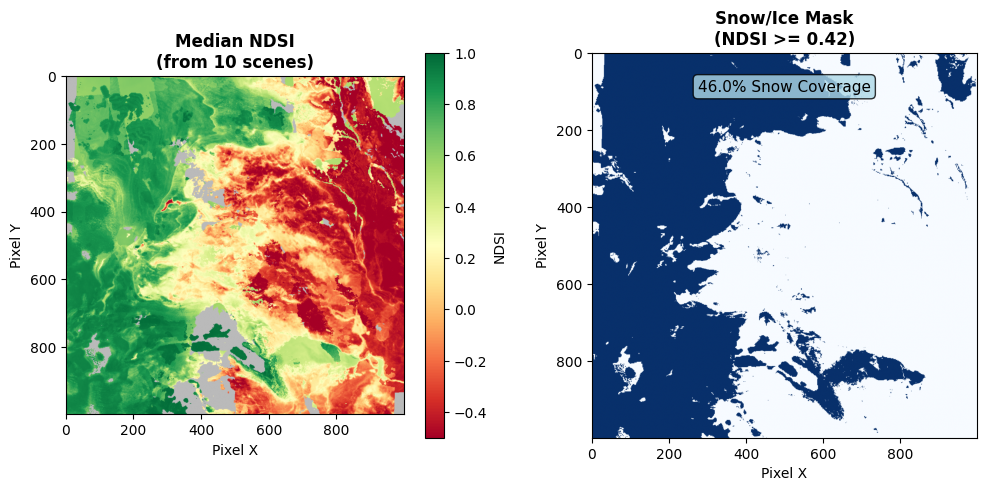

In [ ]:
# Creates a 2-panel diagnostic plot:
# 1. Median NDSI map (spectral snow index)
# 2. Binary snow/ice mask (pixels where NDSI >= threshold)

if result:
    # Create visualization of NDSI and snow mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Median NDSI with NaN values highlighted in gray
    cmap_ndsi = plt.cm.RdYlGn.copy()
    cmap_ndsi.set_bad(color='darkgray', alpha=0.8)  # Highlight NaN values
    im1 = axes[0].imshow(result['ndsi_median'].values, cmap=cmap_ndsi, vmin=-0.5, vmax=1.0)
    axes[0].set_title(f'Median NDSI\n(from {result["scene_count"]} scenes)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Pixel X')
    axes[0].set_ylabel('Pixel Y')
    plt.colorbar(im1, ax=axes[0], label='NDSI')
    
    # Plot 2: Snow/Ice Mask
    axes[1].imshow(result['snow_mask'].values, cmap='Blues', vmin=0, vmax=1)
    axes[1].set_title(f'Snow/Ice Mask\n(NDSI >= {NDSI_THRESHOLD})', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Pixel X')
    axes[1].set_ylabel('Pixel Y')
    
    # Add percentage annotation
    axes[1].text(0.5, 0.9, f'{result["snow_percentage"]:.1f}% Snow Coverage', 
                 transform=axes[1].transAxes, ha='center', fontsize=11, 
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
else:
    print("No results to visualize.")

The purpose of the following cell is to give the user a chance to compare the NDSI grid with the "real image" (RGB).

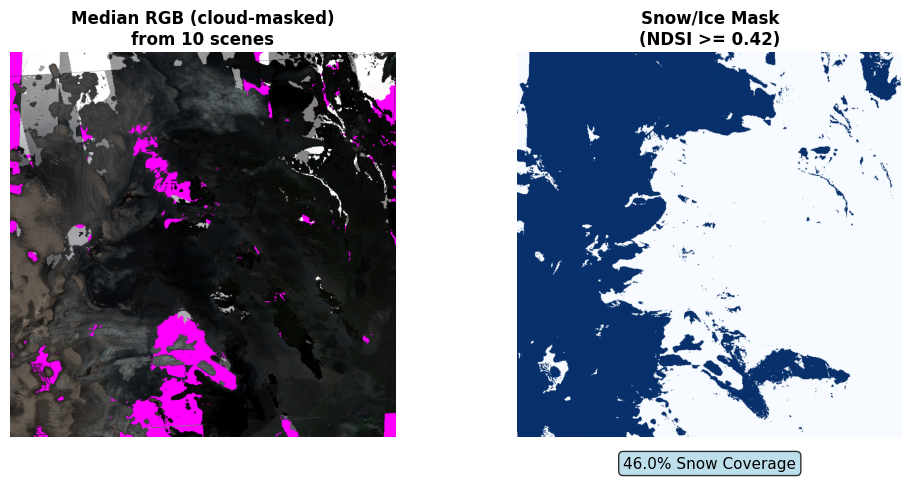

In [ ]:
if result and rgb_result:
    rgb_da = rgb_result['rgb_median']
    rgb_np = np.stack([
        rgb_da.sel(band="R").values,
        rgb_da.sel(band="G").values,
        rgb_da.sel(band="B").values
    ], axis=-1)

    valid_vals = rgb_np[np.isfinite(rgb_np)]
    if valid_vals.size == 0:
        print("RGB composite is empty after masking")
    else:
        low, high = np.nanpercentile(valid_vals, [2, 98])
        rgb_stretched = (rgb_np - low) / (high - low + 1e-6)
        rgb_stretched = np.clip(rgb_stretched, 0, 1)
        
        # Mark NaN values in pink before replacing them
        nan_mask = np.isnan(rgb_stretched).any(axis=-1)  # Find pixels with any NaN channel
        rgb_stretched = np.nan_to_num(rgb_stretched, nan=0.0)
        rgb_stretched[nan_mask] = [1.0, 0.0, 1.0]  # Set NaN pixels to pink (magenta)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].imshow(rgb_stretched)
        axes[0].set_title(f"Median RGB (cloud-masked)\nfrom {rgb_result['scene_count']} scenes", fontsize=12, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(result['snow_mask'].values, cmap='Blues', vmin=0, vmax=1)
        axes[1].set_title(f"Snow/Ice Mask\n(NDSI >= {NDSI_THRESHOLD})", fontsize=12, fontweight='bold')
        axes[1].axis('off')
        axes[1].text(0.5, -0.08, f"{result['snow_percentage']:.1f}% Snow Coverage",
                     transform=axes[1].transAxes, ha='center', fontsize=11,
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
else:
    print("RGB or NDSI result missing; run previous cell first.")

#### 3.2.7 Step 6 & 7: Spatial Expansion and Complete Algorithm

**Goal**: Implement spatial expansion and combine all steps into a complete glacier monitoring algorithm.

**Spatial Expansion Logic**:
- If a candidate cell has >30% snow coverage, its 4 direct neighbors (N, S, E, W) become candidates
- Only unprocessed cells are added to avoid infinite loops
- Process continues until no new candidates are added

**Complete Algorithm**:
1. Load seeds and create grid with initial candidates (cells containing seeds)
2. **Iteration loop**:
   - Process each unprocessed candidate cell:
     - Query STAC for Sentinel-2 scenes
     - Compute median NDSI
     - Apply spatial expansion if >30% snow coverage
     - Add neighbors as new candidates
   - Mark cell as processed
   - Continue until no new candidates remain
3. Combine all NDSI results into single ISN2004 grid
4. Generate statistics and final snow/ice mask

The following cell contains two helper functions, which handle the iterative spatial expansion.

In [ ]:
def get_neighbor_cells(cell_id, grid):
    """
    Get the 4 direct neighbors (N, S, E, W) of a grid cell.
    
    Parameters:
    -----------
    cell_id : int
        ID of the cell to get neighbors for
    grid : gpd.GeoDataFrame
        Grid with all cells
    
    Returns:
    --------
    list : List of neighbor cell IDs that exist in the grid
    """
    cell = grid[grid['cell_id'] == cell_id].iloc[0]
    cell_geom = cell.geometry
    centroid = cell_geom.centroid
    
    # Calculate neighbor positions (10 km grid)
    neighbors = []
    offsets = [
        (0, GRID_SIZE),   # North
        (0, -GRID_SIZE),  # South
        (GRID_SIZE, 0),   # East
        (-GRID_SIZE, 0)   # West
    ]
    
    for dx, dy in offsets:
        neighbor_point = Point(centroid.x + dx, centroid.y + dy)
        # Find cell that contains this point
        matching_cells = grid[grid.contains(neighbor_point)]
        if len(matching_cells) > 0:
            neighbors.append(matching_cells.iloc[0]['cell_id'])
    
    return neighbors


def apply_spatial_expansion(grid, cell_id, snow_percentage, threshold=0.30):
    """
    Apply spatial expansion: if snow coverage exceeds threshold,
    mark all unprocessed neighbors as candidates.
    
    Parameters:
    -----------
    grid : gpd.GeoDataFrame
        Grid with cells and their status
    cell_id : int
        ID of the cell to expand from
    snow_percentage : float
        Snow coverage percentage (0-100)
    threshold : float
        Threshold for expansion (default 0.30 = 30%)
    
    Returns:
    --------
    int : Number of new candidates added
    """
    if snow_percentage / 100.0 < threshold:
        return 0
    
    neighbors = get_neighbor_cells(cell_id, grid)
    new_candidates = 0
    
    for neighbor_id in neighbors:
        neighbor = grid.loc[grid['cell_id'] == neighbor_id]
        if len(neighbor) > 0:
            # Only add if not already a candidate and not yet processed
            if not neighbor.iloc[0]['is_candidate'] and not neighbor.iloc[0].get('is_processed', False):
                grid.loc[grid['cell_id'] == neighbor_id, 'is_candidate'] = True
                new_candidates += 1
    
    return new_candidates

This is the final All-In-One function, which combines all the functions shown before. You can try to run it, but we recommend to use the `glacier_monitoring.py` because the processing of all of Iceland can take hours and a lot of jupyter notebooks can crash during this process.

In [ ]:
def run_glacier_monitoring(seeds, grid_bounds, grid_size, epsg_code, 
                          date_start, date_end, stac_url,
                          ndsi_threshold, snow_threshold, max_scenes=100):
    """
    Complete glacier monitoring algorithm with spatial expansion.
    
    Executes steps 1-7 of the algorithm:
    1. Create grid and mark initial candidates
    2. Iterate: Process candidates, compute NDSI, apply spatial expansion
    3. Combine results into single snow/ice mask
    
    Parameters:
    -----------
    seeds : gpd.GeoDataFrame
        Glacier seed points in ISN2004
    grid_bounds : list
        [minx, miny, maxx, maxy] for grid creation
    grid_size : int
        Grid cell size in meters
    epsg_code : int
        EPSG code for Iceland projection
    date_start, date_end : str
        Time period for Sentinel-2 data
    stac_url : str
        STAC catalog URL
    ndsi_threshold : float
        NDSI threshold for snow/ice classification
    snow_threshold : float
        Snow coverage threshold for spatial expansion (0-1)
    max_scenes : int
        Maximum scenes to process per cell
    
    Returns:
    --------
    dict : Results containing:
        - 'ndsi_combined': xr.DataArray with combined NDSI grid
        - 'snow_mask_combined': xr.DataArray with final snow/ice mask
        - 'grid': gpd.GeoDataFrame with processed cells
        - 'statistics': dict with processing statistics
    """
    print("=" * 80)
    print("GLACIER MONITORING ALGORITHM - SPATIAL EXPANSION")
    print("=" * 80)
    
    # Step 1: Create grid and mark initial candidates
    print("\n[Step 1] Creating grid and marking initial candidates...")
    grid = create_grid(grid_bounds, grid_size)
    grid = mark_candidate_cells(grid, seeds)
    grid['is_processed'] = False
    grid['snow_percentage'] = None
    
    initial_candidates = grid['is_candidate'].sum()
    print(f"   Initial candidates (cells with seeds): {initial_candidates}")
    
    # Prepare result storage
    ndsi_results = {}  # cell_id -> ndsi_array
    cell_bounds_dict = {}  # cell_id -> bounds
    
    # Step 2: Iteration loop with spatial expansion
    iteration = 0
    total_processed = 0
    total_expansion_adds = 0
    
    while True:
        iteration += 1
        # Get unprocessed candidates
        unprocessed = grid[(grid['is_candidate']) & (~grid['is_processed'])]
        
        if len(unprocessed) == 0:
            print(f"\n[Iteration {iteration}] No more candidates to process. Algorithm complete!")
            break
        
        if iteration > MAX_ITERATIONS:
            print(f"\n[Iteration {iteration}] Reached maximum iterations ({MAX_ITERATIONS}). Stopping.")
            break
        
        print(f"\n[Iteration {iteration}] Processing {len(unprocessed)} candidate cells...")
        
        iteration_adds = 0
        cells_with_snow = 0
        
        for idx, cell_row in unprocessed.iterrows():
            cell_id = cell_row['cell_id']
            cell_geom = cell_row.geometry
            cell_bounds = cell_geom.bounds
            
            print(f"  Cell {cell_id} (seed_count={cell_row.get('seed_count', 0)})...", end=" ")
            
            # Query STAC for this cell
            items = query_stac_for_cell(
                cell=cell_row,
                date_start=date_start,
                date_end=date_end,
                epsg_code=epsg_code,
                stac_url=stac_url,
                verbose=False
            )
            
            if len(items) == 0:
                print("no scenes found, skipped")
                grid.loc[grid['cell_id'] == cell_id, 'is_processed'] = True
                continue
            
            # Compute NDSI for this cell
            result = compute_median_ndsi_for_cell(
                stac_items=items,
                cell_bounds=cell_bounds,
                epsg_code=epsg_code,
                max_scenes=max_scenes
            )
            
            if result is None:
                print("   NDSI computation failed")
                grid.loc[grid['cell_id'] == cell_id, 'is_processed'] = True
                continue
            
            # Store result
            ndsi_results[cell_id] = result['ndsi_median']
            cell_bounds_dict[cell_id] = cell_bounds
            snow_pct = result['snow_percentage']
            
            # Add results to grid
            grid.loc[grid['cell_id'] == cell_id, 'snow_percentage'] = snow_pct
            
            print(f"   Snow coverage: {snow_pct:.1f}%")
            
            # Apply spatial expansion
            if snow_pct > 0:
                cells_with_snow += 1
                new_adds = apply_spatial_expansion(
                    grid, cell_id, snow_pct, threshold=snow_threshold
                )
                if new_adds > 0:
                    print(f"   → Added {new_adds} neighbors as candidates")
                    iteration_adds += new_adds
            
            # Mark as processed
            grid.loc[grid['cell_id'] == cell_id, 'is_processed'] = True
            total_processed += 1
        
        total_expansion_adds += iteration_adds
        print(f"   Iteration summary: {len(unprocessed)} processed, {cells_with_snow} with snow, {iteration_adds} new candidates added")
    
    # Step 3: Combine all NDSI results into single grid
    print(f"\n[Step 3] Combining {len(ndsi_results)} NDSI results into unified grid...")
    
    if len(ndsi_results) == 0:
        print("ERROR: No valid NDSI results to combine!")
        return None
    
    # Determine combined grid extent
    all_bounds = list(cell_bounds_dict.values())
    global_minx = min(b[0] for b in all_bounds)
    global_miny = min(b[1] for b in all_bounds)
    global_maxx = max(b[2] for b in all_bounds)
    global_maxy = max(b[3] for b in all_bounds)
    
    # Create combined grid (10m resolution)
    combined_x = np.arange(global_minx, global_maxx, 10)
    combined_y = np.arange(global_miny, global_maxy, 10)
    combined_ndsi = np.full((len(combined_y), len(combined_x)), np.nan, dtype=float)
    
    # Fill in NDSI values from each cell
    for cell_id, ndsi_array in ndsi_results.items():
        bounds = cell_bounds_dict[cell_id]
        minx, miny, maxx, maxy = bounds
        
        # Find indices in combined grid
        x_start = int((minx - global_minx) / 10)
        x_end = int((maxx - global_minx) / 10)
        y_start = int((miny - global_miny) / 10)
        y_end = int((maxy - global_miny) / 10)
        
        # Insert NDSI values
        ndsi_values = ndsi_array.values
        combined_ndsi[y_start:y_end, x_start:x_end] = ndsi_values
    
    # Create xarray DataArray
    ndsi_combined = xr.DataArray(
        combined_ndsi,
        dims=['y', 'x'],
        coords={'x': combined_x, 'y': combined_y},
        attrs={
            'crs': f'EPSG:{epsg_code}',
            'description': 'Combined median NDSI from all processed cells',
            'algorithm': 'Zarr-optimized glacier monitoring with spatial expansion'
        }
    )
    
    # Create final snow/ice mask
    snow_mask_combined = ndsi_combined >= ndsi_threshold
    
    # Calculate statistics
    valid_pixels = np.sum(~np.isnan(combined_ndsi))
    snow_pixels = np.sum(snow_mask_combined.values)
    snow_area_km2 = (snow_pixels * 10 * 10) / 1e6  # 10m pixels to km²
    total_area_km2 = (valid_pixels * 10 * 10) / 1e6
    
    statistics = {
        'total_cells_processed': total_processed,
        'initial_candidates': initial_candidates,
        'expansion_added_cells': total_expansion_adds,
        'iterations': iteration,
        'valid_pixels': int(valid_pixels),
        'snow_ice_pixels': int(snow_pixels),
        'snow_ice_coverage_km2': snow_area_km2,
        'total_valid_area_km2': total_area_km2,
        'snow_ice_percentage': 100.0 * snow_pixels / valid_pixels if valid_pixels > 0 else 0
    }
    
    # Print final statistics
    print("\n" + "=" * 80)
    print("ALGORITHM COMPLETED - FINAL STATISTICS")
    print("=" * 80)
    print(f"Total cells processed:        {statistics['total_cells_processed']}")
    print(f"  - Initial candidates:       {statistics['initial_candidates']}")
    print(f"  - Added by expansion:       {statistics['expansion_added_cells']}")
    print(f"Total iterations:             {statistics['iterations']}")
    print(f"Valid pixels analyzed:        {statistics['valid_pixels']:,}")
    print(f"Snow/Ice pixels detected:     {statistics['snow_ice_pixels']:,}")
    print(f"Snow/Ice area:                {statistics['snow_ice_coverage_km2']:.2f} km²")
    print(f"Total analyzed area:          {statistics['total_valid_area_km2']:.2f} km²")
    print(f"Snow/Ice coverage:            {statistics['snow_ice_percentage']:.2f}%")
    print("=" * 80)
    
    return {
        'ndsi_combined': ndsi_combined,
        'snow_mask_combined': snow_mask_combined,
        'grid': grid,
        'statistics': statistics
    }

In [ ]:
# ======================================================================
# Execute Complete Glacier Monitoring Algorithm
# ======================================================================

# Run the complete algorithm with spatial expansion
final_result = run_glacier_monitoring(
    seeds=seeds,
    grid_bounds=BOUNDING_BOX_ICELAND,
    grid_size=GRID_SIZE,
    epsg_code=EPSG_ICELAND,
    date_start=DATE_START,
    date_end=DATE_END,
    stac_url=STAC_URL,
    ndsi_threshold=NDSI_THRESHOLD,
    snow_threshold=SNOW_PERCENTAGE_THRESHOLD,
    max_scenes=100
)

if final_result:
    print("\n✓ Algorithm completed successfully!")
    print(f"✓ Combined NDSI grid shape: {final_result['ndsi_combined'].shape}")
    print(f"✓ Snow/Ice mask created with {final_result['statistics']['snow_ice_pixels']:,} pixels")
else:
    print("\n✗ Algorithm failed!")

GLACIER MONITORING ALGORITHM - SPATIAL EXPANSION

[Step 1] Creating grid and marking initial candidates...
   Initial candidates (cells with seeds): 87

[Iteration 1] Processing 87 candidate cells...
  Cell 267 (seed_count=3)... 
Processing up to 100 scenes from 13 available...
  [1/13] S2C_MSIL2A_20250729T125321_N05... loaded, reprojected to ISN2004
  [2/13] S2B_MSIL2A_20250727T130259_N05... loaded, reprojected to ISN2004
  [3/13] S2B_MSIL2A_20250726T233649_N05...   Error loading S2B_MSIL2A_20250726T233649_N0511_R030_T60VXR_20250726T235502.zarr: zero-size array to reduction operation fmin which has no identity
skipped (empty or error)
  [4/13] S2B_MSIL2A_20250726T233649_N05...   Error loading S2B_MSIL2A_20250726T233649_N0511_R030_T01VCL_20250726T235502.zarr: zero-size array to reduction operation fmin which has no identity
skipped (empty or error)
  [5/13] S2B_MSIL2A_20250713T232639_N05...   Error loading S2B_MSIL2A_20250713T232639_N0511_R130_T60VXR_20250713T234845.zarr: No group foun

ValueError: Must have equal len keys and value when setting with an ndarray

To visualize the results, you can start by rendering the interactive map with the grid again. You can see what were the seeds and starting cells, and the new cells processed through the spatial expansion. Each cell now also contains the `snow_percantage` value.

In [ ]:
# ======================================================================
# Visualization: Final Results (Interactive Folium Map)
# ======================================================================
# Shows processed grid cells with color-coded snow coverage
# Similar to the Grid visualization from Step 2, but with processed cells

if final_result:
    processed_grid = final_result['grid'][final_result['grid']['is_processed']].copy()
    
    # Separate initial cells (with seeds) from expansion cells
    initial_cells_gdf = processed_grid[processed_grid['seed_count'] > 0]
    expansion_cells_gdf = processed_grid[processed_grid['seed_count'] == 0]
    
    # Additional statistics
    print(f"\nProcessed cells by origin:")
    print(f"  Initial (with seeds): {len(initial_cells_gdf)}")
    print(f"  Added by expansion:   {len(expansion_cells_gdf)}")
    
    # Transform to WGS84 for web mapping (folium requires WGS84)
    processed_grid_wgs84 = processed_grid.to_crs(epsg=4326)
    initial_cells_wgs84 = initial_cells_gdf.to_crs(epsg=4326)
    expansion_cells_wgs84 = expansion_cells_gdf.to_crs(epsg=4326)
    seeds_wgs84 = seeds.to_crs(epsg=4326)
    
    # Calculate center for map
    center_lat = processed_grid_wgs84.geometry.centroid.y.mean()
    center_lon = processed_grid_wgs84.geometry.centroid.x.mean()
    
    # Create interactive map with satellite imagery
    map_results = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=7,
        tiles=None
    )
    
    # Add Esri World Imagery
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri World Imagery',
        name='Satellite Imagery',
        overlay=False,
        control=True
    ).add_to(map_results)
    
    # Add initial cells (with seeds) in blue
    if len(initial_cells_wgs84) > 0:
        folium.GeoJson(
            initial_cells_wgs84[['cell_id', 'seed_count', 'snow_percentage', 'geometry']],
            name='Initial Cells (with seeds)',
            style_function=lambda x: {
                'fillColor': 'blue',
                'color': 'darkblue',
                'weight': 2.5,
                'fillOpacity': 0.4,
                'opacity': 0.7
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['cell_id', 'seed_count', 'snow_percentage'],
                aliases=['Cell ID:', 'Seeds:', 'Snow Coverage'],
                localize=True
            ),
            popup=folium.GeoJsonPopup(
                fields=['cell_id', 'seed_count', 'snow_percentage'],
                aliases=['Cell ID:', 'Number of Seeds:', 'Snow Coverage']
            )
        ).add_to(map_results)
    
    # Add expansion cells (no seeds) in green
    if len(expansion_cells_wgs84) > 0:
        folium.GeoJson(
            expansion_cells_wgs84[['cell_id', 'snow_percentage', 'geometry']],
            name='Expansion Cells',
            style_function=lambda x: {
                'fillColor': 'lightgreen',
                'color': 'green',
                'weight': 2.5,
                'fillOpacity': 0.4,
                'opacity': 0.7
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['cell_id', 'snow_percentage'],
                aliases=['Cell ID:', 'Snow Coverage'],
                localize=True
            ),
            popup=folium.GeoJsonPopup(
                fields=['cell_id', 'snow_percentage'],
                aliases=['Cell ID (expansion):', 'Snow Coverage']
            )
        ).add_to(map_results)
    
    # Add seed points as feature group
    seed_group = folium.FeatureGroup(name='Glacier Seeds')
    for idx, row in seeds_wgs84.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=3,
            color='red',
            fill=True,
            fillColor='red',
            fillOpacity=0.7,
            popup=f"<b>Seed {idx}</b>",
            tooltip="Glacier Seed"
        ).add_to(seed_group)
    
    seed_group.add_to(map_results)
    
    # Add fullscreen button
    plugins.Fullscreen().add_to(map_results)
    
    # Add layer control (allows toggling layers on/off)
    folium.LayerControl(collapsed=False).add_to(map_results)
    
    # Print summary statistics
    print(f"\n✓ Interactive map created with {len(processed_grid)} processed cells")
    print(f"  Blue cells: Initial candidates (with seeds) - {len(initial_cells_wgs84)}")
    print(f"  Green cells: Added by spatial expansion - {len(expansion_cells_wgs84)}")
    print(f"  Total snow/ice coverage: {final_result['statistics']['snow_ice_coverage_km2']:.0f} km²")
    print(f"\nTip: Use the layer control in the top right to toggle layers on/off")
    
    # Display map (must be last expression in cell to render)
    display(map_results)
else:
    print("No results to visualize.")


Processed cells by origin:
  Initial (with seeds): 87
  Added by expansion:   783

✓ Interactive map created with 870 processed cells
  Blue cells: Initial candidates (with seeds) - 87
  Green cells: Added by spatial expansion - 783
  Total snow/ice coverage: 27778 km²

Tip: Use the layer control in the top right to toggle layers on/off


There is also a possibility to visualize the final grid. But as it covers all of Iceland, it may exceed you RAM capacity. 

In [ ]:
# ======================================================================
# Visualization: Final Grid
# ======================================================================

if final_result:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Combined NDSI
    im1 = axes[0].imshow(
        final_result['ndsi_combined'].values,
        cmap='RdYlGn',
        vmin=-0.5,
        vmax=1.0,
        extent=[
            final_result['ndsi_combined'].x.min(),
            final_result['ndsi_combined'].x.max(),
            final_result['ndsi_combined'].y.min(),
            final_result['ndsi_combined'].y.max()
        ]
    )
    axes[0].set_title(
        f"Combined NDSI Map\n({final_result['statistics']['total_cells_processed']} cells processed)",
        fontsize=13,
        fontweight='bold'
    )
    axes[0].set_xlabel('X (ISN2004) [m]')
    axes[0].set_ylabel('Y (ISN2004) [m]')
    plt.colorbar(im1, ax=axes[0], label='NDSI', fraction=0.046)
    
    # Plot 2: Final Snow/Ice Mask
    im2 = axes[1].imshow(
        final_result['snow_mask_combined'].values,
        cmap='Blues',
        vmin=0,
        vmax=1,
        extent=[
            final_result['snow_mask_combined'].x.min(),
            final_result['snow_mask_combined'].x.max(),
            final_result['snow_mask_combined'].y.min(),
            final_result['snow_mask_combined'].y.max()
        ]
    )
    axes[1].set_title(
        f"Final Snow/Ice Mask\n({final_result['statistics']['snow_ice_coverage_km2']:.0f} km²)",
        fontsize=13,
        fontweight='bold'
    )
    axes[1].set_xlabel('X (ISN2004) [m]')
    axes[1].set_ylabel('Y (ISN2004) [m]')
    plt.colorbar(im2, ax=axes[1], label='Snow/Ice', fraction=0.046, ticks=[0, 1])
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics plot
    processed_grid = final_result['grid'][final_result['grid']['is_processed']]
    print(f"\nProcessed cells by origin:")
    print(f"  Initial (with seeds): {(processed_grid['seed_count'] > 0).sum()}")
    print(f"  Added by expansion:   {(processed_grid['seed_count'] == 0).sum()}")
else:
    print("No results to visualize.")

MemoryError: Unable to allocate 2.12 GiB for an array with shape (40000, 57000) and data type bool

Error in callback <function _draw_all_if_interactive at 0x000002B76242D3A0> (for post_execute), with arguments args (),kwargs {}:


MemoryError: Unable to allocate 17.0 GiB for an array with shape (40000, 57000) and data type float64

MemoryError: Unable to allocate 17.0 GiB for an array with shape (40000, 57000) and data type float64

<Figure size 1600x700 with 3 Axes>

If your device don't have enough RAM-Capazity you can downsample the grid with the following script and try to visualize the results again.

Creating downsampled visualization (factor: 20)...


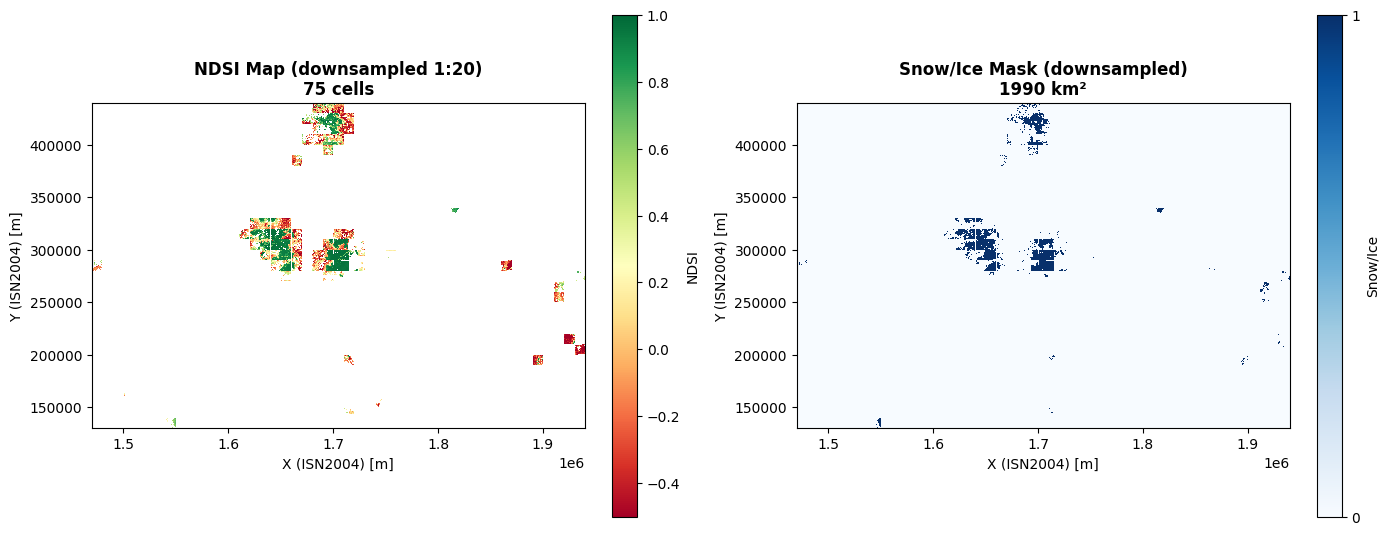

✓ Downsampled plots created
  Original size: (31000, 47000)
  Downsampled size: (1550, 2350)
  Memory reduction: ~400x


In [ ]:
# ======================================================================
# Optional: Downsampled NDSI/Snow Mask Visualization
# ======================================================================
# Only use this if you want to see the NDSI data (uses downsampling to save RAM)

if final_result:
    # Downsample factor (e.g., 10 = every 10th pixel)
    downsample_factor = 20  # Adjust this if still too much RAM
    
    print(f"Creating downsampled visualization (factor: {downsample_factor})...")
    
    # Downsample the data
    ndsi_downsampled = final_result['ndsi_combined'].values[::downsample_factor, ::downsample_factor]
    snow_downsampled = final_result['snow_mask_combined'].values[::downsample_factor, ::downsample_factor]
    
    # Create downsampled coordinates
    x_down = final_result['ndsi_combined'].x.values[::downsample_factor]
    y_down = final_result['ndsi_combined'].y.values[::downsample_factor]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Downsampled NDSI
    im1 = axes[0].imshow(
        ndsi_downsampled,
        cmap='RdYlGn',
        vmin=-0.5,
        vmax=1.0,
        extent=[x_down.min(), x_down.max(), y_down.min(), y_down.max()],
        interpolation='nearest'
    )
    axes[0].set_title(
        f"NDSI Map (downsampled 1:{downsample_factor})\n{final_result['statistics']['total_cells_processed']} cells",
        fontsize=12,
        fontweight='bold'
    )
    axes[0].set_xlabel('X (ISN2004) [m]')
    axes[0].set_ylabel('Y (ISN2004) [m]')
    plt.colorbar(im1, ax=axes[0], label='NDSI', fraction=0.046)
    
    # Plot 2: Downsampled Snow Mask
    im2 = axes[1].imshow(
        snow_downsampled,
        cmap='Blues',
        vmin=0,
        vmax=1,
        extent=[x_down.min(), x_down.max(), y_down.min(), y_down.max()],
        interpolation='nearest'
    )
    axes[1].set_title(
        f"Snow/Ice Mask (downsampled)\n{final_result['statistics']['snow_ice_coverage_km2']:.0f} km²",
        fontsize=12,
        fontweight='bold'
    )
    axes[1].set_xlabel('X (ISN2004) [m]')
    axes[1].set_ylabel('Y (ISN2004) [m]')
    plt.colorbar(im2, ax=axes[1], label='Snow/Ice', fraction=0.046, ticks=[0, 1])
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Downsampled plots created")
    print(f"  Original size: {final_result['ndsi_combined'].shape}")
    print(f"  Downsampled size: {ndsi_downsampled.shape}")
    print(f"  Memory reduction: ~{downsample_factor**2}x")
else:
    print("No results to visualize.")

## 4. Native-Like Algorithm
This algorithm implements a workflow for monitoring snow and ice in Iceland using Sentinel-2 data via the EOPF Zarr format.

---

### DISCLAIMER: Known Issues

**The native-like Alogrithm currently does not execute successfully due to memory constraints.**

- The Sentinel-L2A scenes from the EOPF Zarr store are extremely large (full scene extents)
- Even loading a single scene causes JupyterHub to crash due to insufficient memory
- The native-like workflow approach (loading full scenes instead of tiles) is not feasible in resource-constrained environments
---

### 4.1 Load Libaries

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from shapely.geometry import box
import shapely.geometry
import pystac_client
from pystac import Item
import xarray as xr
import os
import requests
from datetime import datetime
from pyproj import Transformer
import dask
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed

### 4.2 Loading Seeds

They are here just for displaying purposes.

In [2]:
# Load seeds
seeds_gdf = gpd.read_file("data/Iceland_Seeds.geojson")

# Reproject to WGS84 for search
seeds_gdf = seeds_gdf.to_crs("EPSG:4326")

# Get bounding box in WGS84
total_bounds = seeds_gdf.total_bounds
bbox_4326 = list(total_bounds) # [minx, miny, maxx, maxy]

# Define AOI for UTM transformation
spatial_extent = {
    "west": bbox_4326[0],
    "south": bbox_4326[1],
    "east": bbox_4326[2],
    "north": bbox_4326[3],
}

print(f"Bbox (EPSG:4326): {bbox_4326}")

# Convert AOI to UTM 27N (EPSG:32627) - Common for Iceland
# The example used EPSG:32631 for Belgium. For Iceland, we use 32627.
target_crs = "EPSG:32627"
transformer = Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)

west_utm, south_utm = transformer.transform(
    spatial_extent["west"], spatial_extent["south"]
)
east_utm, north_utm = transformer.transform(
    spatial_extent["east"], spatial_extent["north"]
)

# Spatial slice parameters (Note: y is typically north-to-south in these grids, so slice order matters)
# We will verify the order after inspection, but typically it is slice(max_y, min_y) or slice(min_y, max_y) depending on the index.
# The example used slice(north_utm, south_utm) for y, implying descending coordinates.
x_slice = slice(west_utm, east_utm)
y_slice = slice(north_utm, south_utm)

print(f"UTM Bounds ({target_crs}): West={west_utm}, South={south_utm}, East={east_utm}, North={north_utm}")


Bbox (EPSG:4326): [np.float64(-23.77593305479282), np.float64(63.644977182030495), np.float64(-13.940908081882865), np.float64(66.20015537924486)]
UTM Bounds (EPSG:32627): West=362535.61403618613, South=7060438.683328982, East=817331.8137813979, North=7360136.248818787


### 4.3 STAC Search and Data Loading

This section connects to the EOPF STAC catalog and searches for Sentinel-2 L2A scenes within a specified time range and bounding box.

**What this code does:**
- Opens a connection to the EOPF STAC catalog (`stac.core.eopf.eodc.eu`)
- Searches for Sentinel-2 Level-2A products within the defined time range and AOI
- Filters out deprecated items and extracts product URLs (hrefs)
- In `SINGLE_SCENE_MODE`, selects a specific scene for testing

**Algorithm approach:**
This algorithm simulates a **file-based workflow** by processing full Sentinel-2 scenes retrieved from the EOPF Zarr store. It avoids tile-based optimization and instead loads the full scene extent to compute NDSI and classify snow.

> **Warning:** This approach is memory-intensive. Loading full scenes may exceed available RAM.

In [3]:
# === Configuration ===
SINGLE_SCENE_MODE = True  # Toggle: True = specific scene, False = all scenes
SINGLE_SCENE_NAME = "S2A_MSIL2A_20250721T125321_N0511_R138_T27WWM_20250721T185714.zarr"
    
# STAC Search
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Search for Sentinel-2 L2A items
time_range_str = "2025-07-01/2025-07-31"

print(f"Searching STAC for {time_range_str} over AOI...")
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox_4326,
    datetime=time_range_str,
)

items = list(search.items())
print(f"Found {len(items)} items.")

# Filter: only non-deprecated items with 'product' asset
valid_items = [
    item for item in items 
    if not item.properties.get("deprecated", False) and "product" in item.assets
]
print(f"Valid items with product asset: {len(valid_items)}")

# Get hrefs for file-based processing
hrefs = [item.assets["product"].href for item in valid_items]

# Apply single scene toggle
if SINGLE_SCENE_MODE:
    # Find the specific scene
    matching = [h for h in hrefs if SINGLE_SCENE_NAME in h]
    if matching:
        hrefs = [matching[0]]
        print(f"\n[SINGLE_SCENE_MODE] Using specific scene: {SINGLE_SCENE_NAME}")
    elif hrefs:
        hrefs = [hrefs[0]]
        print(f"\n[SINGLE_SCENE_MODE] Specific scene not found, using first: {os.path.basename(hrefs[0])}")
elif hrefs:
    print(f"\nTotal scenes to process: {len(hrefs)}")

Searching STAC for 2025-07-01/2025-07-31 over AOI...
Found 107 items.
Valid items with product asset: 107

[SINGLE_SCENE_MODE] Using specific scene: S2A_MSIL2A_20250721T125321_N0511_R138_T27WWM_20250721T185714.zarr


### 4.4 Native-Like Scene Processing

#### What is a "Native-Like" Workflow?

In traditional satellite image processing, scientists download entire image files to their computer and process them locally. This is how algorithms were originally designed before cloud computing existed.

**This notebook simulates that traditional approach:**
- We treat each Sentinel-2 scene as a complete "file" 
- We load the full scene into memory
- We process it entirely before moving to the next scene

This is in contrast to modern **tile-based** approaches where only small chunks of data are loaded as needed.

#### What happens in this section?

1. **Load a scene** → Download the satellite image bands we need (Green and SWIR channels)
2. **Calculate snow index** → Apply the NDSI formula to identify snow/ice pixels
3. **Create a mask** → Mark which pixels are snow and which are not

#### Why doesn't it work?

The Sentinel-2 scenes from the EOPF store are very large (hundreds of MB to GB per scene). When we try to load an entire scene into memory at once, JupyterHub runs out of RAM and crashes, even with just one scene.

> **Bottom line:** This approach demonstrates the algorithm logic, but cannot actually run in resource-limited environments like our JupyterHub.

In [4]:
def load_scene(href, x_slice, y_slice, use_full_scene=True):
    """
    Load a single Sentinel-2 scene from EOPF Zarr store.
    Returns bands B03 (Green), B11 (SWIR), and SCL mask aligned to 10m grid.
    
    Parameters:
    -----------
    href : str
        Path to the Zarr store
    x_slice, y_slice : slice
        AOI bounds (used for scene selection, not clipping if use_full_scene=True)
    use_full_scene : bool
        If True, loads the entire scene extent instead of clipping to AOI.
        This ensures scenes at AOI boundaries are fully processed.
    """
    scene_name = os.path.basename(href.rstrip("/"))
    print(f"Loading scene: {scene_name}")
    
    # Load Green Band (B03) - 10m resolution
    ds_b03_full = xr.open_zarr(href, group="/measurements/reflectance/r10m")[["b03"]]
    
    if use_full_scene:
        # Use full scene extent - no clipping
        ds_b03 = ds_b03_full
        print(f"  → Using full scene extent")
    else:
        # Clip to AOI
        ds_b03 = ds_b03_full.sel(x=x_slice, y=y_slice)
    
    # Load SWIR Band (B11) - 20m resolution
    ds_b11_full = xr.open_zarr(href, group="/measurements/reflectance/r20m")[["b11"]]
    
    if use_full_scene:
        ds_b11 = ds_b11_full
    else:
        ds_b11 = ds_b11_full.sel(x=x_slice, y=y_slice)
    
    # Load SCL (Scene Classification) - 20m resolution
    ds_scl_full = xr.open_zarr(href, group="/conditions/mask/l2a_classification/r20m")[["scl"]]
    
    if use_full_scene:
        ds_scl = ds_scl_full
    else:
        ds_scl = ds_scl_full.sel(x=x_slice, y=y_slice)
    
    # Resample 20m bands to 10m grid
    ds_b11_interp = ds_b11.interp_like(ds_b03, method="nearest")
    ds_scl_interp = ds_scl.interp_like(ds_b03, method="nearest")
    
    # Merge into single dataset
    scene_data = xr.merge([ds_b03, ds_b11_interp, ds_scl_interp])
    
    # Extract datetime from filename
    parts = scene_name.split("_")
    date_str = next((p for p in parts if p.startswith("20") and "T" in p), None)
    if date_str:
        scene_data.attrs["datetime"] = datetime.strptime(date_str.split(".")[0], "%Y%m%dT%H%M%S")
    
    scene_data.attrs["scene_name"] = scene_name
    return scene_data


def compute_ndsi(scene_data):
    """
    Compute NDSI (Normalized Difference Snow Index) and snow mask.
    NDSI = (Green - SWIR) / (Green + SWIR)
    Snow threshold: NDSI > 0.42
    """
    green = scene_data["b03"]
    swir = scene_data["b11"]
    scl = scene_data["scl"]
    
    # Calculate NDSI
    denom = green + swir
    ndsi = (green - swir) / denom.where(denom != 0)
    
    # Mask: exclude Nodata (0), Saturated (1), Cloud Shadows (3)[it can see snow even if there are cloud shadows], Water (6), Unclassified (7), Cloud Medium (8), Cloud High (9)
    valid_mask = ~scl.isin([0,1,6,7,8,9])
    
    # Snow classification (NDSI > 0.42 and valid pixel)
    snow_mask = (ndsi > 0.42) & valid_mask
    
    return xr.Dataset({
        "ndsi": ndsi,
        "snow_mask": snow_mask,
        "valid_mask": valid_mask,
    }, attrs=scene_data.attrs)


def process_scenes(hrefs, x_slice, y_slice, use_full_scene=True):
    """
    Process all scenes in file-based workflow.
    Returns list of results (one per scene).
    
    Parameters:
    -----------
    use_full_scene : bool
        If True, processes entire scene extent instead of clipping to AOI.
    """
    results = []
    
    for i, href in enumerate(hrefs):
        print(f"\n[{i+1}/{len(hrefs)}] Processing...")
        try:
            # Load scene
            scene_data = load_scene(href, x_slice, y_slice, use_full_scene=use_full_scene)
            
            # Compute NDSI and snow mask
            result = compute_ndsi(scene_data)
            
            # Trigger computation
            result = result.compute()
            
            # Statistics
            snow_pixels = result["snow_mask"].sum().item()
            valid_pixels = result["valid_mask"].sum().item()
            snow_percent = (snow_pixels / valid_pixels * 100) if valid_pixels > 0 else 0
            
            print(f"  → Snow pixels: {snow_pixels:,} ({snow_percent:.1f}% of valid area)")
            
            results.append(result)
            
        except Exception as e:
            print(f"  → Error: {e}")
            continue
    
    return results


# === Configuration ===
USE_FULL_SCENE = True  # True = process entire scene, False = clip to AOI

# Process scenes
if hrefs:
    print(f"Starting file-based processing of {len(hrefs)} scene(s)...")
    print(f"Mode: {'Full scene extent' if USE_FULL_SCENE else 'Clipped to AOI'}\n")
    results = process_scenes(hrefs, x_slice, y_slice, use_full_scene=USE_FULL_SCENE)
    print(f"\n✓ Successfully processed {len(results)} scene(s)")
else:
    print("No scenes to process.")

Starting file-based processing of 1 scene(s)...
Mode: Full scene extent


[1/1] Processing...
Loading scene: S2A_MSIL2A_20250721T125321_N0511_R138_T27WWM_20250721T185714.zarr
  → Using full scene extent
  → Snow pixels: 13,305,291 (17.6% of valid area)

✓ Successfully processed 1 scene(s)


### 4.5 Visualization: Stacked Scene Composite

This section creates a composite from multiple processed scenes.

**What this code does:**
- Stacks scenes and computes the **median NDSI** (robust against outliers and clouds)
- Builds a **valid mask** (pixel valid in at least one scene)
- Applies the valid mask to the median NDSI for cleaner visualization
- Creates an aggregated snow mask based on the median NDSI threshold
- Calculates snow coverage statistics

**Why use median?**
Using the median across multiple scenes helps to:
- Reduce noise from clouds that weren't fully masked
- Create a more stable snow/ice classification
- Fill gaps where individual scenes had invalid data

In [5]:
# ======================================================================
# Stack Results and Compute Composite
# ======================================================================
# Combines all processed scenes into a single composite using median/mean

NDSI_THRESHOLD = 0.42  # Standard snow threshold

def create_stacked_composite(results):
    """
    Stack all scene results and compute composite metrics.
    - Median NDSI (robust against outliers/clouds)
    - Aggregated snow mask (snow if detected in majority of valid scenes)
    """
    if not results:
        return None
    
    scene_count = len(results)
    print(f"Stacking {scene_count} scene(s)...")
    
    if scene_count == 1:
        # Single scene: use directly
        ndsi_median = results[0]["ndsi"]
        snow_mask = results[0]["snow_mask"]
        valid_mask = results[0]["valid_mask"]
    else:
        # Multiple scenes: stack along new dimension and compute median
        ndsi_stack = xr.concat([r["ndsi"] for r in results], dim="scene")
        valid_stack = xr.concat([r["valid_mask"] for r in results], dim="scene")
        
        # Median NDSI (ignoring NaN)
        ndsi_median = ndsi_stack.median(dim="scene", skipna=True)
        
        # Valid mask: pixel valid in at least one scene
        valid_mask = valid_stack.any(dim="scene")
        
        # Snow mask from median NDSI
        snow_mask = (ndsi_median > NDSI_THRESHOLD) & valid_mask
    
    # Apply valid mask to NDSI for clean visualization
    ndsi_median = ndsi_median.where(valid_mask)
    
    # Calculate statistics
    total_pixels = valid_mask.size
    valid_pixels = valid_mask.sum().item()
    snow_pixels = snow_mask.sum().item()
    snow_percentage = (snow_pixels / valid_pixels * 100) if valid_pixels > 0 else 0
    
    print(f"  → Total pixels: {total_pixels:,}")
    print(f"  → Valid pixels: {valid_pixels:,}")
    print(f"  → Snow pixels: {snow_pixels:,} ({snow_percentage:.1f}%)")
    
    return {
        "ndsi_median": ndsi_median,
        "snow_mask": snow_mask,
        "valid_mask": valid_mask,
        "scene_count": scene_count,
        "snow_percentage": snow_percentage
    }


# Create composite from results
if 'results' in dir() and results:
    composite = create_stacked_composite(results)
else:
    composite = None
    print("No results available. Run processing cell first.")

Stacking 1 scene(s)...
  → Total pixels: 120,560,400
  → Valid pixels: 75,653,712
  → Snow pixels: 13,305,291 (17.6%)


### 4.6 NDSI Visualization

Creates a 2-panel diagnostic plot:
1. **Median NDSI Map** - Shows the spectral snow index values (-0.5 to 1.0). Green indicates snow/ice (high NDSI), red indicates bare ground/water (low NDSI).
2. **Binary Snow/Ice Mask** - Shows classified snow pixels where NDSI ≥ 0.42.

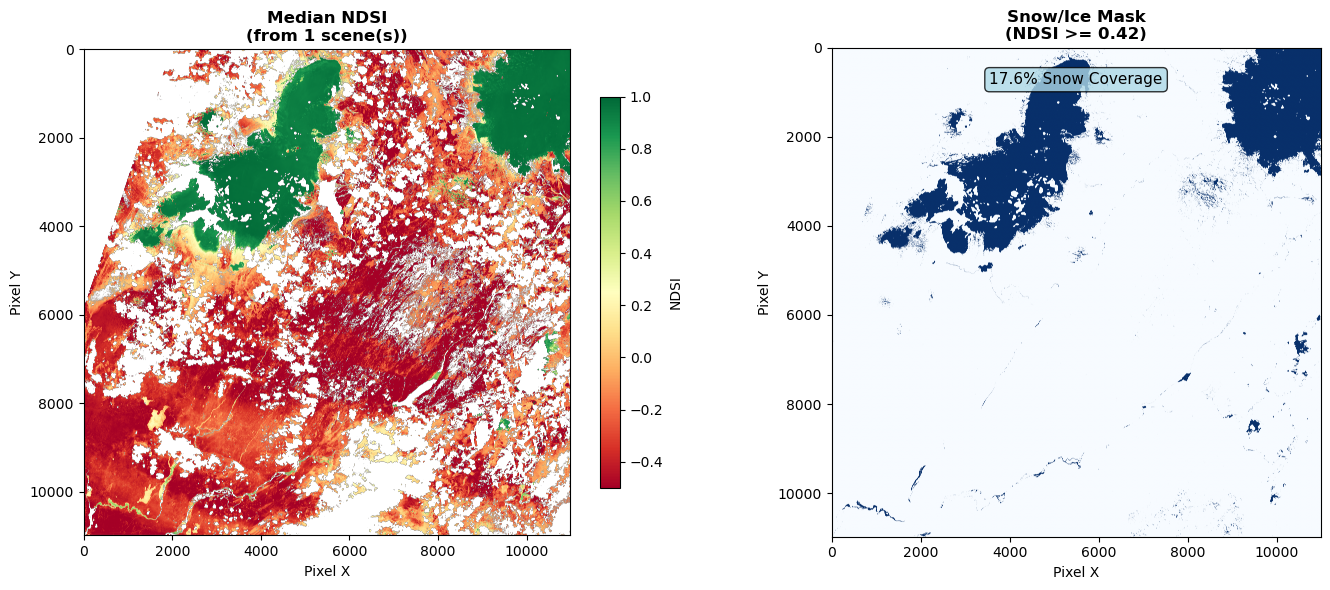


✓ Visualization complete
  Scenes processed: 1
  Snow coverage: 17.6%


In [6]:
# ======================================================================
# Visualization: NDSI and Snow/Ice Classification Results
# ======================================================================
# Creates a 2-panel diagnostic plot:
# 1. Median NDSI map (spectral snow index)
# 2. Binary snow/ice mask (pixels where NDSI >= threshold)

if composite:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # ----- Plot 1: Median NDSI -----
    ndsi_data = composite['ndsi_median'].values
    im1 = axes[0].imshow(ndsi_data, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    axes[0].set_title(f'Median NDSI\n(from {composite["scene_count"]} scene(s))', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Pixel X')
    axes[0].set_ylabel('Pixel Y')
    plt.colorbar(im1, ax=axes[0], label='NDSI', shrink=0.8)
    
    # ----- Plot 2: Snow/Ice Mask -----
    snow_data = composite['snow_mask'].values.astype(float)
    im2 = axes[1].imshow(snow_data, cmap='Blues', vmin=0, vmax=1)
    axes[1].set_title(f'Snow/Ice Mask\n(NDSI >= {NDSI_THRESHOLD})', 
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Pixel X')
    axes[1].set_ylabel('Pixel Y')
    
    # Add percentage annotation
    axes[1].text(0.5, 0.95, f'{composite["snow_percentage"]:.1f}% Snow Coverage', 
                 transform=axes[1].transAxes, ha='center', va='top', fontsize=11, 
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualization complete")
    print(f"  Scenes processed: {composite['scene_count']}")
    print(f"  Snow coverage: {composite['snow_percentage']:.1f}%")
else:
    print("No composite available. Run stacking cell first.")

### 4.7 RGB Visualization

This section loads RGB bands **independently** from the NDSI processing to avoid data interference.

**Why separate processing?**
- Keeps the NDSI data pipeline clean and unmodified
- RGB is only for visualization purposes
- Uses 60m resolution bands to minimize memory usage

**What this code does:**
- Loads B02 (Blue), B03 (Green), B04 (Red) at 60m resolution
- Builds a median RGB composite **without cloud masking** to keep full visual context
- Applies percentile stretching for better visualization

In [7]:
# ======================================================================
# RGB Processing - Separate from NDSI
# ======================================================================
# Loads RGB bands at 60m resolution to minimize memory/container load

def load_rgb_scene(href, x_slice, y_slice, use_full_scene=True):
    """
    Load RGB bands (B02, B03, B04) at 60m resolution for a single scene.
    Uses 60m bands for minimal data volume and container load.
    
    Parameters:
    -----------
    use_full_scene : bool
        If True, loads the entire scene extent instead of clipping to AOI.
    """
    scene_name = os.path.basename(href.rstrip("/"))
    
    # Load 60m RGB bands (lowest resolution = minimal data)
    ds_rgb = xr.open_zarr(href, group="/measurements/reflectance/r60m")[["b02", "b03", "b04"]]
    
    if use_full_scene:
        # Use full scene extent - no clipping
        print(f"  → Using full scene extent")
    else:
        # Clip to AOI
        ds_rgb = ds_rgb.sel(x=x_slice, y=y_slice)
    
    return ds_rgb


def create_rgb_composite(hrefs, x_slice, y_slice, use_full_scene=True):
    """
    Create median RGB composite from all scenes.
    No cloud mask is applied to keep true visual context.
    
    Parameters:
    -----------
    use_full_scene : bool
        If True, processes entire scene extent instead of clipping to AOI.
    """
    print(f"Loading RGB data from {len(hrefs)} scene(s)...")
    print(f"Mode: {'Full scene extent' if use_full_scene else 'Clipped to AOI'}")
    
    rgb_scenes = []
    for i, href in enumerate(hrefs):
        try:
            scene = load_rgb_scene(href, x_slice, y_slice, use_full_scene=use_full_scene)
            rgb_scenes.append(scene.compute())
            print(f"  [{i+1}/{len(hrefs)}] Loaded: {os.path.basename(href)}")
        except Exception as e:
            print(f"  [{i+1}/{len(hrefs)}] Error: {e}")
            continue
    
    if not rgb_scenes:
        return None
    
    if len(rgb_scenes) == 1:
        # Single scene
        rgb_median = xr.concat([
            rgb_scenes[0]["b04"],
            rgb_scenes[0]["b03"],
            rgb_scenes[0]["b02"],
        ], dim="band").assign_coords(band=["R", "G", "B"])
    else:
        # Stack and compute median
        r_stack = xr.concat([s["b04"] for s in rgb_scenes], dim="scene")
        g_stack = xr.concat([s["b03"] for s in rgb_scenes], dim="scene")
        b_stack = xr.concat([s["b02"] for s in rgb_scenes], dim="scene")
        
        rgb_median = xr.concat([
            r_stack.median(dim="scene", skipna=True),
            g_stack.median(dim="scene", skipna=True),
            b_stack.median(dim="scene", skipna=True),
        ], dim="band").assign_coords(band=["R", "G", "B"])
    
    print(f"✓ RGB composite created from {len(rgb_scenes)} scene(s)")
    return {"rgb_median": rgb_median, "scene_count": len(rgb_scenes)}


# Create RGB composite (independent from NDSI)
if hrefs:
    rgb_composite = create_rgb_composite(hrefs, x_slice, y_slice, use_full_scene=USE_FULL_SCENE)
else:
    rgb_composite = None
    print("No scenes available for RGB processing.")

Loading RGB data from 1 scene(s)...
Mode: Full scene extent
  → Using full scene extent
  [1/1] Loaded: S2A_MSIL2A_20250721T125321_N0511_R138_T27WWM_20250721T185714.zarr
✓ RGB composite created from 1 scene(s)


### 4.8 RGB vs Snow Mask Comparison (60m)

Creates a side-by-side comparison:
1. **Median RGB Composite (60m)** - True color visualization of the scene(s) with 2-98% percentile stretch
2. **Snow/Ice Mask** - Binary classification overlaid for comparison with the visual appearance

RGB COMPOSITE (60m Resolution)
Creating RGB composite from 1 scene(s)...
Mode: Full scene extent
Loading RGB (60m): S2A_MSIL2A_20250721T125321_N0511_R138_T27WWM_20250721T185714.zarr
  → Using full scene extent
  [1/1] Loaded successfully
✓ RGB composite created


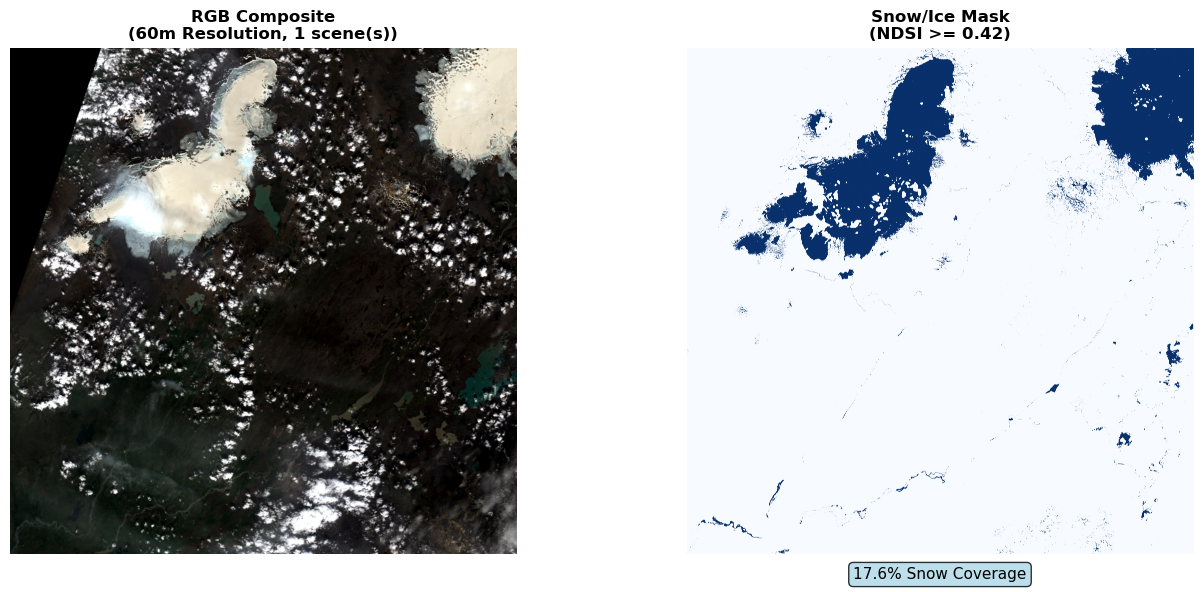


✓ Visualization complete
  Scenes processed: 1
  Snow coverage: 17.6%


In [8]:
# ======================================================================
# Visualization: RGB Composite vs Snow/Ice Mask (60m Resolution)
# ======================================================================
# Shows raw RGB without cloud masking for full visual context

def load_rgb_10m(href, x_slice, y_slice, use_full_scene=True):
    """
    Load RGB bands (B02, B03, B04) at 60m resolution.
    No cloud masking applied - shows full scene.
    
    Parameters:
    -----------
    use_full_scene : bool
        If True, loads the entire scene extent instead of clipping to AOI.
    """
    scene_name = os.path.basename(href.rstrip("/"))
    print(f"Loading RGB (60m): {scene_name}")
    
    # Load 60m RGB bands (B02=Blue, B03=Green, B04=Red)
    ds_10m = xr.open_zarr(href, group="/measurements/reflectance/r60m")[["b02", "b03", "b04"]]
    
    if use_full_scene:
        # Use full scene extent - no clipping
        print(f"  → Using full scene extent")
    else:
        # Clip to AOI
        ds_10m = ds_10m.sel(x=x_slice, y=y_slice)
    
    return ds_10m


def create_rgb_composite_10m(hrefs, x_slice, y_slice, use_full_scene=True):
    """
    Create RGB composite from all scenes at 60m resolution.
    No cloud masking - full visual context preserved.
    
    Parameters:
    -----------
    use_full_scene : bool
        If True, processes entire scene extent instead of clipping to AOI.
    """
    print(f"Creating RGB composite from {len(hrefs)} scene(s)...")
    print(f"Mode: {'Full scene extent' if use_full_scene else 'Clipped to AOI'}")
    
    rgb_scenes = []
    for i, href in enumerate(hrefs):
        try:
            ds_rgb = load_rgb_10m(href, x_slice, y_slice, use_full_scene=use_full_scene)
            ds_rgb = ds_rgb.compute()
            rgb_scenes.append(ds_rgb)
            print(f"  [{i+1}/{len(hrefs)}] Loaded successfully")
            
        except Exception as e:
            print(f"  [{i+1}/{len(hrefs)}] Error: {e}")
            continue
    
    if not rgb_scenes:
        return None
    
    # Stack RGB
    if len(rgb_scenes) == 1:
        rgb_median = xr.concat([
            rgb_scenes[0]["b04"],  # R
            rgb_scenes[0]["b03"],  # G
            rgb_scenes[0]["b02"],  # B
        ], dim="band").assign_coords(band=["R", "G", "B"])
    else:
        # Median across all scenes
        r_stack = xr.concat([s["b04"] for s in rgb_scenes], dim="scene")
        g_stack = xr.concat([s["b03"] for s in rgb_scenes], dim="scene")
        b_stack = xr.concat([s["b02"] for s in rgb_scenes], dim="scene")
        
        rgb_median = xr.concat([
            r_stack.median(dim="scene", skipna=True),
            g_stack.median(dim="scene", skipna=True),
            b_stack.median(dim="scene", skipna=True),
        ], dim="band").assign_coords(band=["R", "G", "B"])
    
    print(f"✓ RGB composite created")
    return {"rgb_median": rgb_median, "scene_count": len(rgb_scenes)}


# Create RGB composite (no cloud masking)
if hrefs:
    print("="*60)
    print("RGB COMPOSITE (60m Resolution)")
    print("="*60)
    rgb_full = create_rgb_composite_10m(hrefs, x_slice, y_slice, use_full_scene=USE_FULL_SCENE)
else:
    rgb_full = None
    print("No scenes available.")

# Visualization
if rgb_full and composite:
    rgb_da = rgb_full['rgb_median']
    r = rgb_da.sel(band="R").values
    g = rgb_da.sel(band="G").values
    b = rgb_da.sel(band="B").values
    
    # Stack RGB
    rgb_np = np.stack([r, g, b], axis=-1).astype("float32")
    
    # Normalize if needed (Sentinel-2 reflectance is often 0-10000)
    max_val = np.nanmax(rgb_np)
    if max_val > 1.5:
        rgb_np = rgb_np / 10000.0
    
    # Replace NaN with 0
    rgb_np = np.nan_to_num(rgb_np, nan=0.0)
    
    # Per-channel percentile stretching (2-98%) for better contrast
    rgb_stretched = np.zeros_like(rgb_np)
    for c in range(3):
        channel = rgb_np[..., c]
        valid = (channel > 0)
        if np.any(valid):
            low, high = np.percentile(channel[valid], [2, 98])
            stretched = (channel - low) / (high - low + 1e-6)
            rgb_stretched[..., c] = np.clip(stretched, 0, 1)
    
    # Gamma correction for better visualization
    gamma = 1.1
    rgb_stretched = np.power(rgb_stretched, 1 / gamma)
    
    # === PLOT ===
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # ----- Plot 1: RGB Composite -----
    axes[0].imshow(rgb_stretched)
    axes[0].set_title(f"RGB Composite\n(60m Resolution, {rgb_full['scene_count']} scene(s))", 
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # ----- Plot 2: Snow/Ice Mask -----
    snow_data = composite['snow_mask'].values.astype(float)
    axes[1].imshow(snow_data, cmap='Blues', vmin=0, vmax=1)
    axes[1].set_title(f"Snow/Ice Mask\n(NDSI >= {NDSI_THRESHOLD})", 
                     fontsize=12, fontweight='bold')
    axes[1].axis('off')
    axes[1].text(0.5, -0.05, f"{composite['snow_percentage']:.1f}% Snow Coverage",
                 transform=axes[1].transAxes, ha='center', fontsize=11,
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualization complete")
    print(f"  Scenes processed: {rgb_full['scene_count']}")
    print(f"  Snow coverage: {composite['snow_percentage']:.1f}%")
else:
    print("RGB or NDSI composite missing.")

### 4.9 Interactive Map: Scene Locations & Processed Area

This section creates an interactive map showing the spatial context of the analysis.

**Map Layers:**
- **Green polygon**: The actual processed composite area (data extent after spatial slicing)
- **Blue polygons**: Full Sentinel-2 scene extents from the STAC catalog
- **Red points**: Glacier seed locations used for the AOI definition
- **Orange dashed box**: Area of Interest (AOI) bounding box

**Features:**
- Esri satellite imagery basemap
- Layer control to toggle visibility of each layer
- Hover over polygons for scene details (ID, date, cloud cover)

In [13]:
# ======================================================================
# Interactive Map with Folium
# ======================================================================
# Shows scene bounding boxes on a satellite background
# Highlights the actual processed area (composite bbox) in green

import folium
from folium import GeoJson, FeatureGroup
from folium.plugins import Fullscreen

# Create GeoDataFrame with all scene bounding boxes (blue)
scene_bboxes = []
for item in valid_items:
    bbox = item.bbox  # [west, south, east, north]
    scene_polygon = box(bbox[0], bbox[1], bbox[2], bbox[3])
    scene_bboxes.append({
        "geometry": scene_polygon,
        "scene_id": item.id,
        "datetime": item.datetime.strftime("%Y-%m-%d %H:%M") if item.datetime else "N/A",
        "cloud_cover": item.properties.get("eo:cloud_cover", "N/A")
    })

scenes_gdf = gpd.GeoDataFrame(scene_bboxes, crs="EPSG:4326")

# === Get Composite BBox (actual processed area) ===
composite_gdf = None
if 'composite' in dir() and composite is not None:
    # Extract coordinates from composite (in UTM)
    try:
        x_coords = composite['ndsi_median'].coords['x'].values
        y_coords = composite['ndsi_median'].coords['y'].values
        
        # Get bounds in UTM
        utm_west = float(x_coords.min())
        utm_east = float(x_coords.max())
        utm_south = float(y_coords.min())
        utm_north = float(y_coords.max())
        
        # Transform back to WGS84
        transformer_to_wgs84 = Transformer.from_crs(target_crs, "EPSG:4326", always_xy=True)
        
        # Transform all 4 corners to handle projection distortion
        sw_lon, sw_lat = transformer_to_wgs84.transform(utm_west, utm_south)
        se_lon, se_lat = transformer_to_wgs84.transform(utm_east, utm_south)
        ne_lon, ne_lat = transformer_to_wgs84.transform(utm_east, utm_north)
        nw_lon, nw_lat = transformer_to_wgs84.transform(utm_west, utm_north)
        
        # Create polygon from corners
        from shapely.geometry import Polygon
        composite_polygon = Polygon([
            (sw_lon, sw_lat),
            (se_lon, se_lat),
            (ne_lon, ne_lat),
            (nw_lon, nw_lat),
            (sw_lon, sw_lat)  # close the ring
        ])
        
        composite_gdf = gpd.GeoDataFrame([{
            "geometry": composite_polygon,
            "name": "Processed Composite Area",
            "scene_count": composite.get("scene_count", 1),
            "snow_coverage": f"{composite.get('snow_percentage', 0):.1f}%"
        }], crs="EPSG:4326")
        
        print(f"Composite bbox (UTM): W={utm_west:.0f}, E={utm_east:.0f}, S={utm_south:.0f}, N={utm_north:.0f}")
        print(f"Composite bbox (WGS84): W={sw_lon:.4f}, E={ne_lon:.4f}, S={sw_lat:.4f}, N={ne_lat:.4f}")
    except Exception as e:
        print(f"Could not extract composite bbox: {e}")

# Calculate map center
if composite_gdf is not None:
    minx, miny, maxx, maxy = composite_gdf.total_bounds
    center_lon = (minx + maxx) / 2
    center_lat = (miny + maxy) / 2
else:
    center_lon = (bbox_4326[0] + bbox_4326[2]) / 2
    center_lat = (bbox_4326[1] + bbox_4326[3]) / 2

# Create map with Esri satellite tiles
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=7,
    tiles=None
)

# Add Esri World Imagery as satellite basemap
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri, Maxar, Earthstar Geographics",
    name="Satellite",
    overlay=False
).add_to(m)

# === Layer 1: All Sentinel-2 Scenes (Blue) ===
scenes_layer = FeatureGroup(name="All Sentinel-2 Scenes")
GeoJson(
    scenes_gdf.__geo_interface__,
    style_function=lambda x: {
        "fillColor": "#3388ff",
        "color": "#3388ff",
        "weight": 2,
        "fillOpacity": 0.15
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["scene_id", "datetime", "cloud_cover"],
        aliases=["Scene ID:", "Date:", "Cloud Cover:"],
        localize=True
    )
).add_to(scenes_layer)
scenes_layer.add_to(m)

# === Layer 2: Composite Processed Area (Green) ===
if composite_gdf is not None:
    composite_layer = FeatureGroup(name="PROCESSED AREA (Composite)")
    GeoJson(
        composite_gdf.__geo_interface__,
        style_function=lambda x: {
            "fillColor": "#00ff00",
            "color": "#00ff00",
            "weight": 5,
            "fillOpacity": 0.25
        },
        tooltip=folium.GeoJsonTooltip(
            fields=["name", "scene_count", "snow_coverage"],
            aliases=["Area:", "Scenes:", "Snow:"],
            localize=True
        )
    ).add_to(composite_layer)
    composite_layer.add_to(m)

# === Layer 3: Seed Points (Red) ===
seeds_layer = FeatureGroup(name="Glacier Seed Points")
for idx, row in seeds_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="#ffffff",
        fill=True,
        fillColor="#ff0000",
        fillOpacity=1.0,
        weight=1
    ).add_to(seeds_layer)
seeds_layer.add_to(m)

# === Layer 4: AOI Bounding Box (Orange) ===
aoi_polygon = box(bbox_4326[0], bbox_4326[1], bbox_4326[2], bbox_4326[3])
aoi_gdf = gpd.GeoDataFrame([{"geometry": aoi_polygon, "name": "AOI"}], crs="EPSG:4326")

aoi_layer = FeatureGroup(name="Area of Interest (AOI)")
GeoJson(
    aoi_gdf.__geo_interface__,
    style_function=lambda x: {
        "fillColor": "transparent",
        "color": "#ff6600",
        "weight": 3,
        "dashArray": "10, 5"
    }
).add_to(aoi_layer)
aoi_layer.add_to(m)

# Add layer control and fullscreen button
folium.LayerControl(collapsed=False).add_to(m)
Fullscreen().add_to(m)

# Print legend
print(f"\n{'='*50}")
print(f"Map Legend:")
if composite_gdf is not None:
    print(f"   Green polygon: Actual processed composite area")
    print(f"    (This is the data extent after spatial slicing)")
print(f"  • Blue polygons: Full Sentinel-2 scene extents ({len(scenes_gdf)})")
print(f"  • Red points: Glacier seed locations ({len(seeds_gdf)})")
print(f"  • Orange dashed: Area of Interest (AOI)")
print(f"{'='*50}")

m

Composite bbox (UTM): W=499985, E=609775, S=7090205, N=7199995
Composite bbox (WGS84): W=-21.0003, E=-18.6799, S=63.9389, N=64.9060

Map Legend:
   Green polygon: Actual processed composite area
    (This is the data extent after spatial slicing)
  • Blue polygons: Full Sentinel-2 scene extents (107)
  • Red points: Glacier seed locations (21)
  • Orange dashed: Area of Interest (AOI)


## 5. Benchmarking
To evaluate the performance of the Zarr Optimize Algorithm, we conducted systematic benchmarks using varying grid cell sizes (1, 5, 10, 12, 15, 18.3, 20, and 25 km). Our benchmarking focused on two key aspects:

- Hardware utilization: Monitoring RAM usage, CPU load, network throughput, and disk I/O during processing using Proxmox API metrics
- Processing efficiency: Measuring total execution time and per-cell timing breakdown

**Methodology**

Each benchmark run processed the same glacier seed point with identical parameters (NDSI threshold, date range, max scenes) while only varying the grid size. Each process was also run on the same VM inside Proxmox, where we used the Proxmox Monitoring API to track hardware and network usage.

Besides tracking the VM's processing power, we also tracked the processing time for each cell and its processing phases:

- STAC Query: Time to search the satellite catalog
- Zarr Loading: Time to fetch and decode satellite data chunks
- NDSI Computation: Time to calculate snow/ice indices

**Analysis**

The benchmark results are visualized in benchmarking_visualization.ipynb, which includes:

- Cell Processing Time Breakdown: A pie chart showing relative time spent in each phase
- Grid Size Comparison: Bar charts comparing different cell sizes
- Hardware Metrics: Time series of RAM, CPU, network, and disk usage
- Performance Ratios: Time per km², time per cell, and total processing time

#### Imports & Configuration

Before generating the benchmark visualizations, we import the necessary libraries and define a consistent color palette used across all charts. The configuration also sets up:

- **`COLORS`**: A dictionary mapping each metric category (STAC query, Zarr loading, NDSI computation, etc.) to a distinct color for consistent visual styling.
- **`get_bar_colors(n)`**: A helper function that generates a gradient of blue shades for bar charts, scaling to the number of grid sizes being compared.
- **Matplotlib defaults**: Figure size, DPI, and font size are standardized so all plots share a uniform appearance.

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import geopandas as gpd

plt.style.use('default')
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

COLORS = {
    'primary': '#2E86AB',
    'stac_query': '#E63946',
    'zarr_load': '#2A9D8F',
    'ndsi_compute': '#264653',
    'tile_save': '#E9C46A',
    'expansion': '#F4A261',
    'ram': '#2E86AB',
    'cpu': '#2A9D8F',
    'network': '#A23B72',
    'disk_read': '#264653',
    'disk_write': '#F18F01',
    'avg_line': '#E63946',
    'max_line': '#F4A261',
    'good': '#2A9D8F',
    'warning': '#F4A261',
    'critical': '#E63946',
}

def get_bar_colors(n):
    return plt.cm.Blues(np.linspace(0.4, 0.9, n))

In [ ]:
OUTPUT_DIR = Path('output')
SINGLE_TEST_DIR = OUTPUT_DIR / 'test_monitored_Right_183k'

CELL_SIZE_TESTS = {
    1: 'test_monitored_Right_1k',
    5: 'test_monitored_Right_5k',
    10: 'test_monitored_Right_10k',
    12: 'test_monitored_Right_12k',
    15: 'test_monitored_Right_15k',
    18.3: 'test_monitored_Right_183k',
    20: 'test_monitored_Right_20k',
    25: 'test_monitored_Right_25k',
}

#### Data Loading

The `load_test_data()` function below reads the three benchmark output files from a given test directory:

- **`statistics_*.json`** — Per-cell timing breakdown (STAC query, Zarr loading, NDSI computation), snow/ice coverage stats, and algorithm configuration.
- **`proxmox_monitoring_*.json`** — Time-series hardware metrics (RAM, CPU, network throughput, disk I/O) collected via the Proxmox VM API during the run.
- **`processed_grid_*.geojson`** — The final spatial grid with `is_processed` flags and `snow_percentage` values per cell.

`SINGLE_TEST_DIR` points to the primary reference run (18.3 km cell size), while `CELL_SIZE_TESTS` maps each grid resolution (1–25 km) to its output folder for systematic comparison.

In [ ]:
# Load Data

def load_test_data(test_dir):
    test_path = Path(test_dir)
    data = {'name': test_path.name, 'path': test_path, 'statistics': None, 'monitoring': None, 'grid': None}
    
    stats_files = list(test_path.glob('statistics_*.json'))
    if stats_files:
        with open(stats_files[0], 'r') as f:
            data['statistics'] = json.load(f)
    
    monitoring_files = list(test_path.glob('proxmox_monitoring_*.json'))
    if monitoring_files:
        with open(monitoring_files[0], 'r') as f:
            data['monitoring'] = json.load(f)
    
    grid_files = list(test_path.glob('processed_grid_*.geojson'))
    if grid_files:
        data['grid'] = gpd.read_file(grid_files[0])
    
    return data

test_data = load_test_data(SINGLE_TEST_DIR)
print(f"Loaded test: {test_data['name']}")
print(f"  Statistics: {'✅' if test_data['statistics'] else '❌'}")
print(f"  Monitoring: {'✅' if test_data['monitoring'] else '❌'}")
print(f"  Grid: {'✅' if test_data['grid'] is not None else '❌'}")

Loaded test: test_monitored_Right_183k
  Statistics: ✅
  Monitoring: ✅
  Grid: ✅


### 5.1 Cell Processing Time Breakdown

This section visualizes how processing time is distributed across the different phases of the algorithm for a single benchmark run (the reference run at 18.3 km grid size).

The **pie chart** below shows the relative share of total processing time spent in each phase:

| Phase | Description |
|-------|-------------|
| **STAC Query** | Searching the EOPF STAC catalog for Sentinel-2 scenes intersecting the cell |
| **Zarr Loading** | Fetching and decoding the relevant Zarr data chunks (B03, B11, SCL bands) |
| **NDSI Computation** | Resampling, reprojecting, calculating NDSI, and deriving the snow/ice mask |
| **Tile Saving** | Writing the per-cell NDSI raster tiles to disk |
| **Spatial Expansion** | Checking neighboring cells and marking new candidates |

This breakdown helps identify the primary bottleneck — typically Zarr Loading or STAC Query — and informs where optimization efforts should focus.

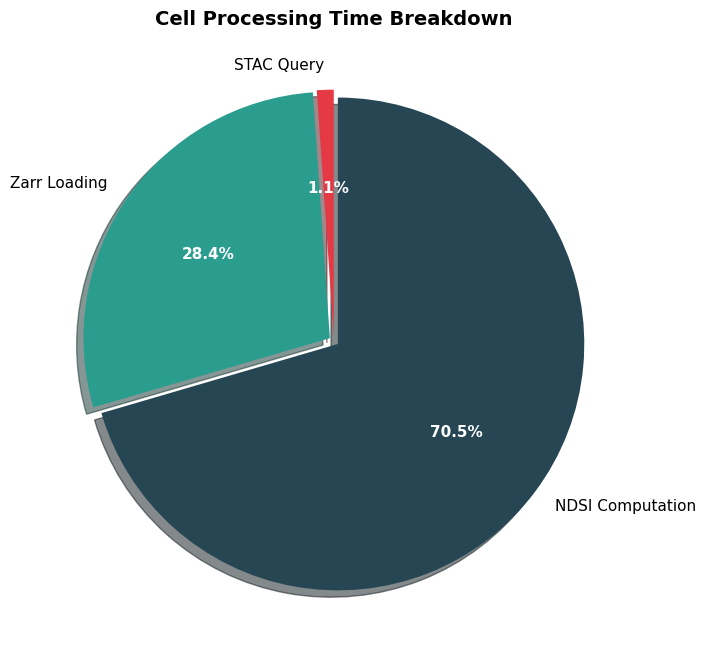

In [ ]:
# Stats Pie Chart:

if test_data['statistics'] and 'cell_timing' in test_data['statistics'].get('results', {}):
    timing = test_data['statistics']['results']['cell_timing']
    time_dist = timing.get('time_distribution_percent', {})
    
    labels = ['STAC Query', 'Zarr Loading', 'NDSI Computation', 'Tile Saving', 'Spatial Expansion']
    sizes = [time_dist.get('stac_query', 0), time_dist.get('zarr_load', 0), time_dist.get('ndsi_compute', 0), 
             time_dist.get('tile_save', 0), time_dist.get('spatial_expansion', 0)]
    
    filtered = [(l, s) for l, s in zip(labels, sizes) if s > 0.1]
    if filtered:
        filtered_labels, filtered_sizes = zip(*filtered)
        pie_colors = [COLORS['stac_query'], COLORS['zarr_load'], COLORS['ndsi_compute'], COLORS['tile_save'], COLORS['expansion']][:len(filtered_labels)]
        
        fig, ax = plt.subplots(figsize=(10, 8))
        wedges, texts, autotexts = ax.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', colors=pie_colors, explode=[0.02]*len(filtered_sizes), shadow=True, startangle=90)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        ax.set_title('Cell Processing Time Breakdown', fontsize=14, fontweight='bold')
        plt.show()
else:
    print("❌ No cell timing data available.")

### 5.2 Cell Size Comparison

This section compares the algorithm's performance across all tested grid cell sizes (1, 5, 10, 12, 15, 18.3, 20, and 25 km). All runs use the same seed point and parameters — only the grid resolution changes.

First, we load the statistics and grid data from every test run. Then a **comparison table** and a set of **six bar charts** are generated:

| Chart | What it shows |
|-------|---------------|
| **Total Processing Time** | End-to-end wall-clock time for the full run. Smaller cells mean more iterations, but each iteration is cheaper. |
| **Cells Processed** | Number of grid cells the algorithm visited. Inversely related to cell area. |
| **Average Time per Cell** | Mean processing time for a single cell. Larger cells load more data, so per-cell time increases. |
| **Snow/Ice Coverage (km²)** | Total area classified as snow/ice. Should converge across grid sizes if the algorithm is consistent. |
| **Snow/Ice Percentage** | Ratio of snow/ice pixels to total valid pixels. Acts as a consistency check. |
| **Null Rate** | Percentage of processed cells where `snow_percentage` is `NaN` (e.g., cells fully masked by clouds). High null rates indicate data quality issues. Color-coded: green (&le;5%), orange (5–10%), red (&gt;10%). |

Finally, the **result grids** for each cell size are plotted side by side, with cells colored by their snow percentage, providing a spatial overview of how grid resolution affects coverage detection.

In [ ]:
# Load All Tests:

cell_size_data = {}
for size_km, folder_name in CELL_SIZE_TESTS.items():
    folder_path = OUTPUT_DIR / folder_name
    if folder_path.exists():
        cell_size_data[size_km] = load_test_data(folder_path)
        print(f"✅ Loaded {size_km}km")
    else:
        print(f"❌ Not found: {folder_path}")
print(f"\nLoaded {len(cell_size_data)} tests")

✅ Loaded 1km
✅ Loaded 5km
✅ Loaded 10km
✅ Loaded 12km
✅ Loaded 15km
✅ Loaded 18.3km
✅ Loaded 20km
✅ Loaded 25km

Loaded 8 tests



CELL SIZE COMPARISON


Grid Size (km)  Grid Size (m)  Cells Processed  Total Time (s)  \
0             1.0           1000              675        24233.74   
1             5.0           5000               45         1741.41   
2            10.0          10000               20          825.44   
3            12.0          12000               17          775.00   
4            15.0          15000               16          776.23   
5            18.3          18300               10          496.56   
6            20.0          20000               10          498.22   
7            25.0          25000                8          447.10   

   Avg Time/Cell (s)  Snow/Ice km²     Snow %  Null Rate (%)  
0             32.917      483.6250  89.799201       7.912688  
1             35.427      497.9972  70.972822       8.163265  
2             39.189      503.5541  54.974992       4.761905  
3             45.469      507.6755  53.288210       0.000000  
4             48.391      513.5569  43.355905       0.000000  
5             49.527      522.9388  41.500260       0.000000  
6             49.681      510.5283  36.817475       0.000000  
7             55.740      532.5562  34.063274       0.000000

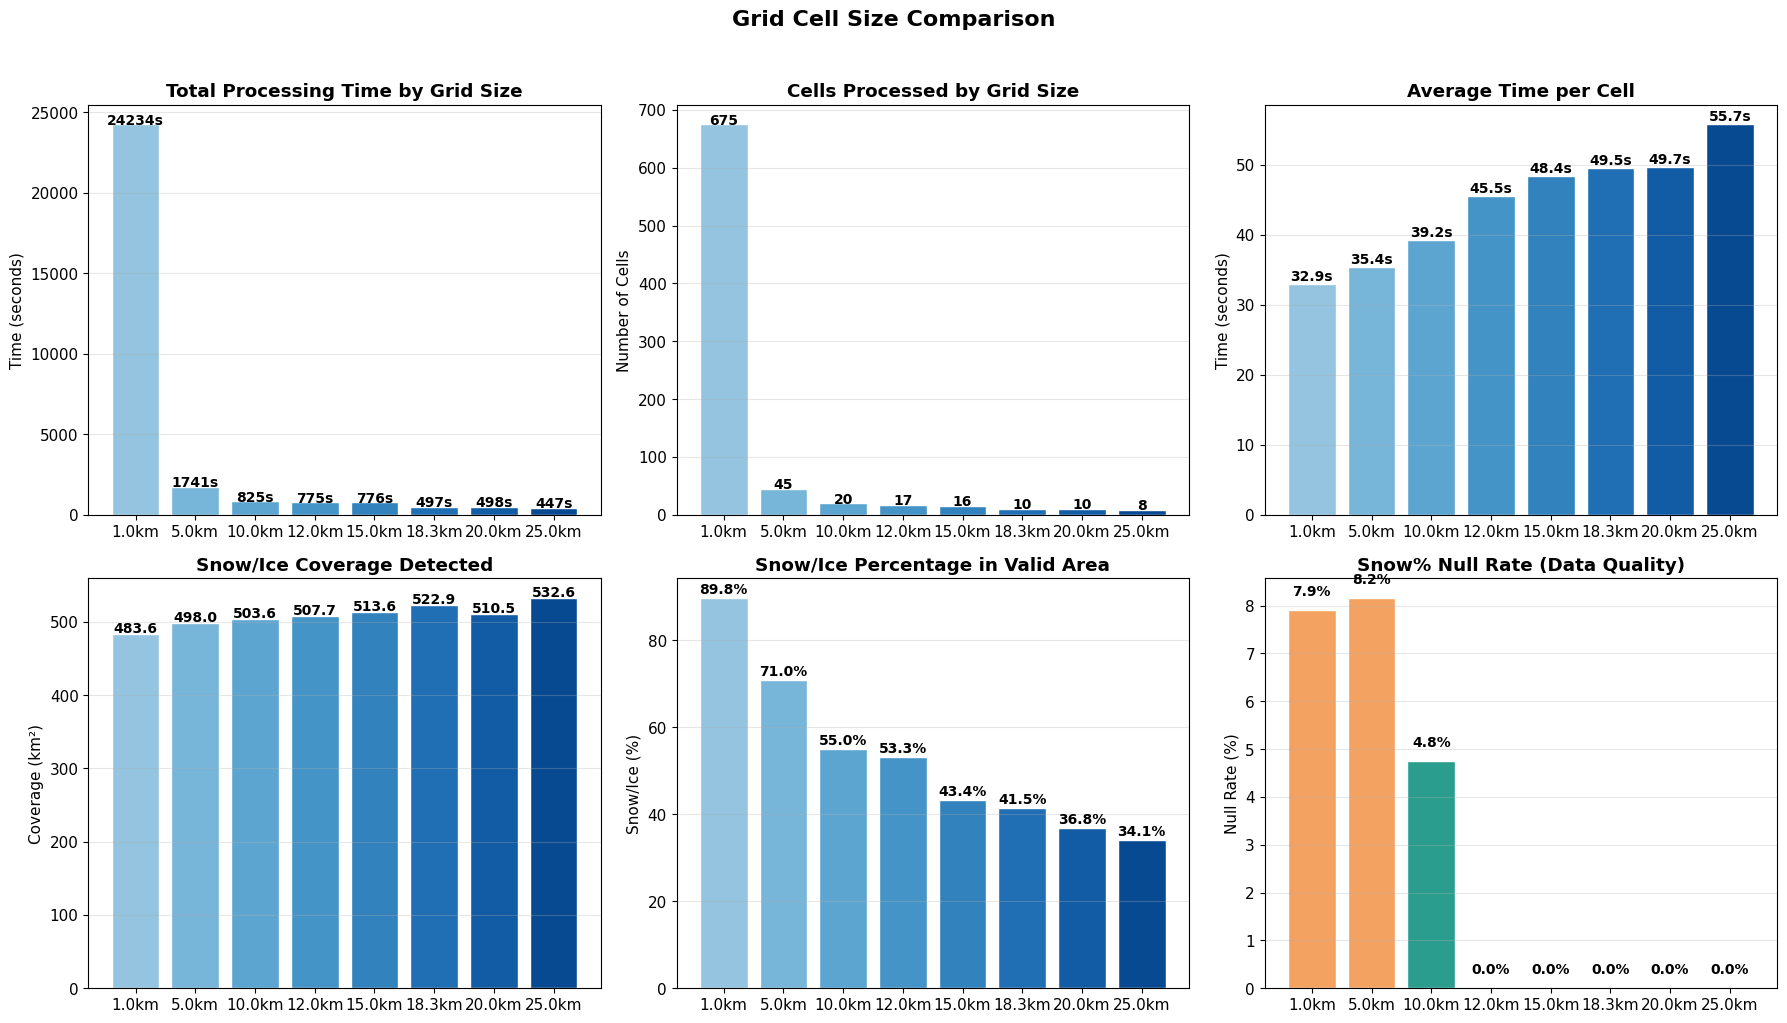

In [ ]:
if len(cell_size_data) >= 1:
    # Prepare comparison data
    comparison = []
    for size_km, data in sorted(cell_size_data.items()):
        if data['statistics']:
            stats = data['statistics']
            config = stats.get('configuration', {})
            results = stats.get('results', {})
            timing = results.get('cell_timing', {})
            
            # Calculate snow_percentage null rate from grid
            null_rate = 0.0
            if data['grid'] is not None:
                grid = data['grid']
                processed = grid[grid['is_processed'] == True]
                if len(processed) > 0 and 'snow_percentage' in processed.columns:
                    null_count = processed['snow_percentage'].isna().sum()
                    null_rate = 100 * null_count / len(processed)
            
            comparison.append({
                'Grid Size (km)': size_km,
                'Grid Size (m)': config.get('grid_size', size_km * 1000),
                'Cells Processed': results.get('total_cells_processed', 0),
                'Total Time (s)': results.get('processing_time_seconds', 0),
                'Avg Time/Cell (s)': timing.get('average_times_per_cell', {}).get('total_seconds', 0),
                'Snow/Ice km²': results.get('snow_ice_coverage_km2', 0),
                'Snow %': results.get('snow_ice_percentage', 0),
                'Null Rate (%)': null_rate,
            })
    
    if comparison:
        comp_df = pd.DataFrame(comparison)
        print("\n" + "=" * 80)
        print("CELL SIZE COMPARISON")
        print("=" * 80)
        display(comp_df)
        
        # Visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        sizes = comp_df['Grid Size (km)'].values
        colors = get_bar_colors(len(sizes))
        
        # Total Processing Time
        ax1 = axes[0, 0]
        bars1 = ax1.bar([f"{s}km" for s in sizes], comp_df['Total Time (s)'], color=colors, edgecolor='white')
        ax1.set_ylabel('Time (seconds)')
        ax1.set_title('Total Processing Time by Grid Size', fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars1, comp_df['Total Time (s)']):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                    f'{val:.0f}s', ha='center', fontsize=10, fontweight='bold')
        
        # Number of Cells
        ax2 = axes[0, 1]
        bars2 = ax2.bar([f"{s}km" for s in sizes], comp_df['Cells Processed'], color=colors, edgecolor='white')
        ax2.set_ylabel('Number of Cells')
        ax2.set_title('Cells Processed by Grid Size', fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars2, comp_df['Cells Processed']):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                    str(int(val)), ha='center', fontsize=10, fontweight='bold')
        
        # Time per Cell
        ax3 = axes[0, 2]
        bars3 = ax3.bar([f"{s}km" for s in sizes], comp_df['Avg Time/Cell (s)'], color=colors, edgecolor='white')
        ax3.set_ylabel('Time (seconds)')
        ax3.set_title('Average Time per Cell', fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars3, comp_df['Avg Time/Cell (s)']):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{val:.1f}s', ha='center', fontsize=10, fontweight='bold')
        
        # Snow Coverage
        ax4 = axes[1, 0]
        bars4 = ax4.bar([f"{s}km" for s in sizes], comp_df['Snow/Ice km²'], color=colors, edgecolor='white')
        ax4.set_ylabel('Coverage (km²)')
        ax4.set_title('Snow/Ice Coverage Detected', fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars4, comp_df['Snow/Ice km²']):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                    f'{val:.1f}', ha='center', fontsize=10, fontweight='bold')
        
        # Snow Percentage
        ax5 = axes[1, 1]
        bars5 = ax5.bar([f"{s}km" for s in sizes], comp_df['Snow %'], color=colors, edgecolor='white')
        ax5.set_ylabel('Snow/Ice (%)')
        ax5.set_title('Snow/Ice Percentage in Valid Area', fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars5, comp_df['Snow %']):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{val:.1f}%', ha='center', fontsize=10, fontweight='bold')
        
        # Null Rate (Data Quality)
        ax6 = axes[1, 2]
        null_colors = [COLORS['critical'] if v > 10 else COLORS['warning'] if v > 5 else COLORS['good'] for v in comp_df['Null Rate (%)']]
        bars6 = ax6.bar([f"{s}km" for s in sizes], comp_df['Null Rate (%)'], color=null_colors, edgecolor='white')
        ax6.set_ylabel('Null Rate (%)')
        ax6.set_title('Snow% Null Rate (Data Quality)', fontweight='bold')
        ax6.grid(True, alpha=0.3, axis='y')
        for bar, val in zip(bars6, comp_df['Null Rate (%)']):
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                    f'{val:.1f}%', ha='center', fontsize=10, fontweight='bold')
        
        plt.suptitle('Grid Cell Size Comparison', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
else:
    print("\n⚠️ Not enough cell size test data for comparison.")
    print("Run tests with different grid sizes and update CELL_SIZE_TESTS configuration.")

#### Spatial Grid Comparison

The following plot shows the processed grid for each cell size side by side. Each small map displays only the cells that were visited during the run, colored by their `snow_percentage` value (darker blue = more snow/ice). This makes it easy to compare:

- **Spatial extent**: Larger cells cover broader areas with fewer tiles, while smaller cells trace the glacier boundary more precisely.
- **Grid granularity**: Finer grids capture more spatial detail but at higher computational cost.
- **Coverage gaps**: Cells where no valid data was available appear without color.

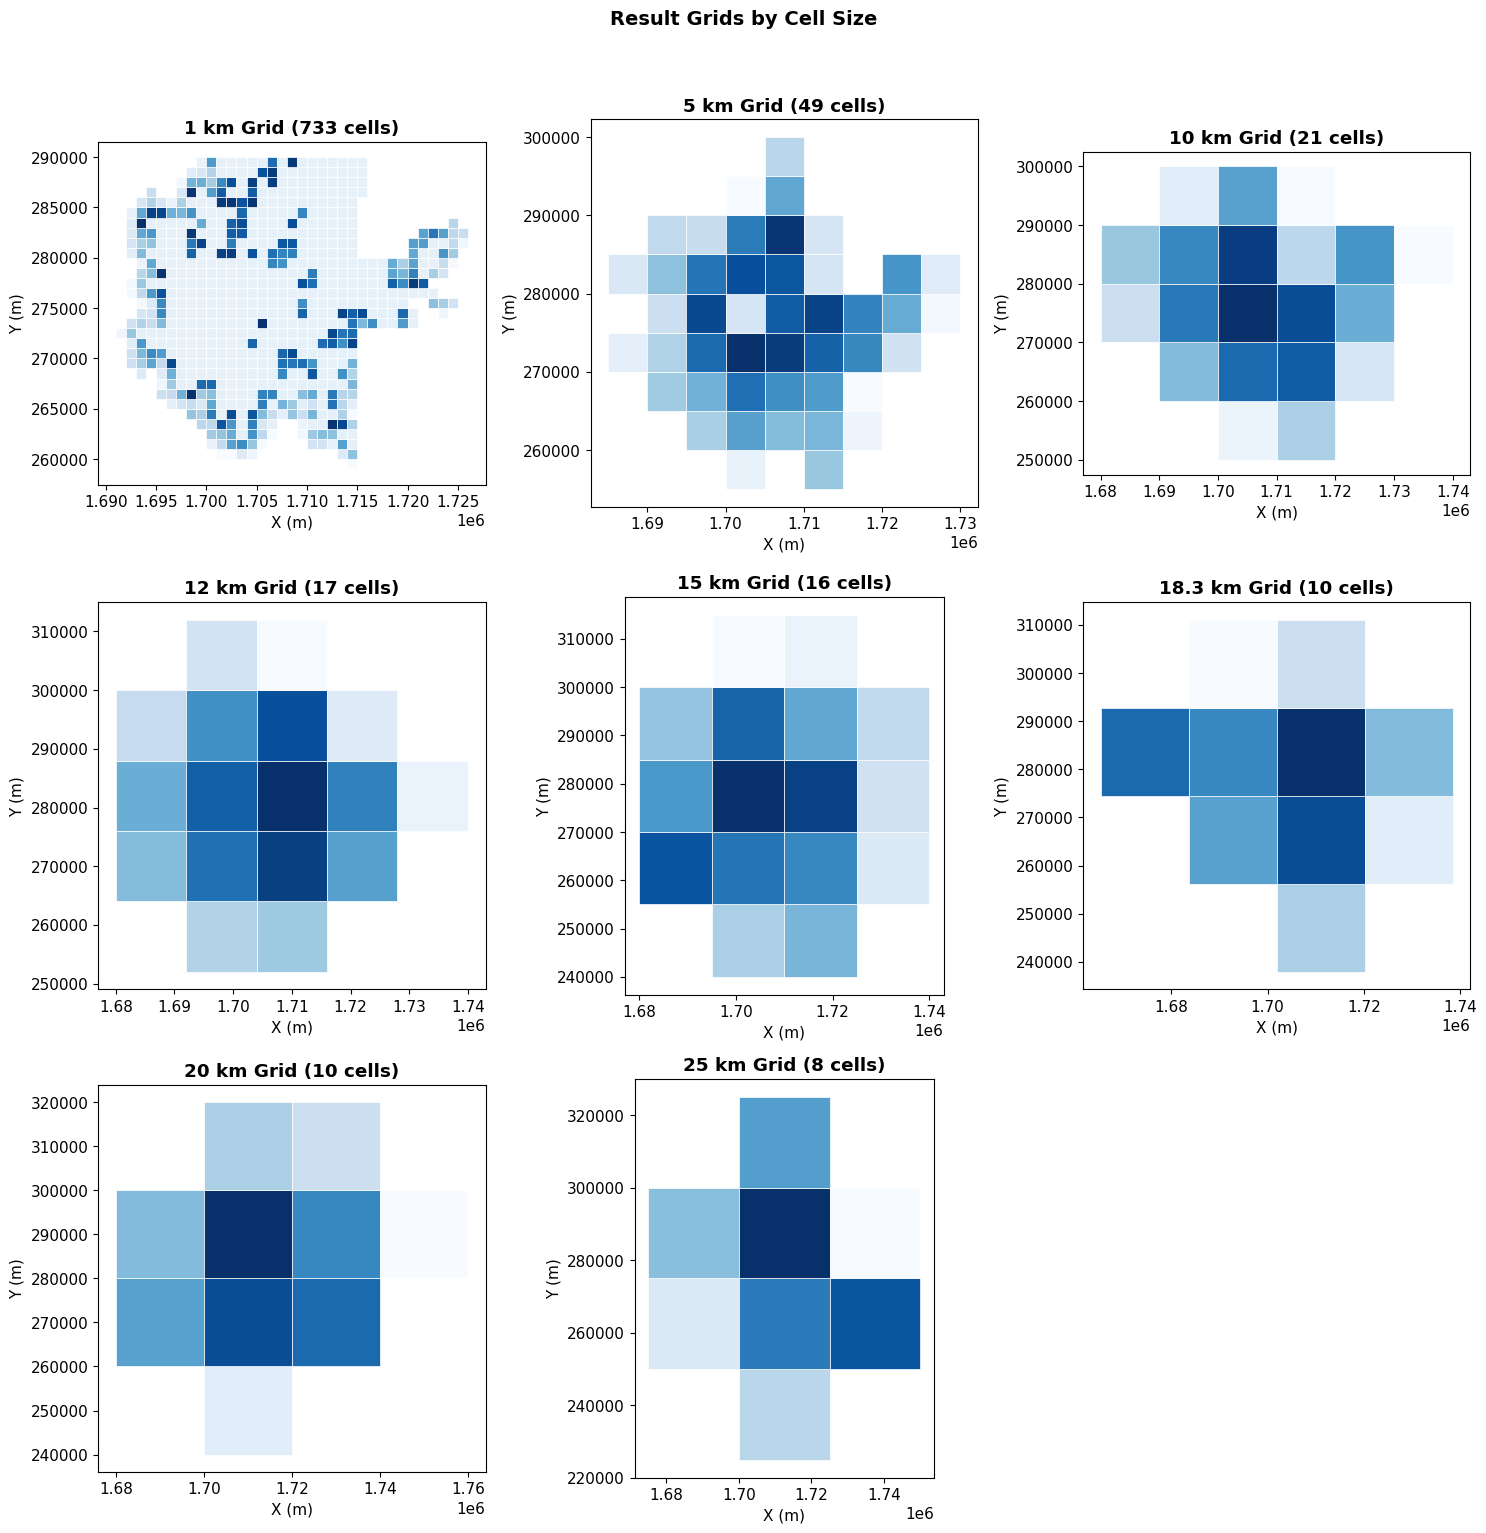

In [ ]:
# Visualize result grids for each cell size
grids_to_show = [(size, data) for size, data in sorted(cell_size_data.items()) if data['grid'] is not None]

if grids_to_show:
    n_grids = len(grids_to_show)
    cols = min(3, n_grids)
    rows = (n_grids + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if n_grids == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    for idx, (size_km, data) in enumerate(grids_to_show):
        ax = axes[idx]
        grid = data['grid']
        
        # Plot grid with snow percentage coloring (no legend)
        processed = grid[grid['is_processed'] == True]
        if 'snow_percentage' in processed.columns and not processed['snow_percentage'].isna().all():
            processed.plot(column='snow_percentage', ax=ax, legend=False, 
                          cmap='Blues', edgecolor='white', linewidth=0.5)
        else:
            processed.plot(ax=ax, color='#4ecdc4', edgecolor='white', linewidth=0.5)
        
        ax.set_title(f'{size_km} km Grid ({len(processed)} cells)', fontweight='bold')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
    
    # Hide empty subplots
    for idx in range(len(grids_to_show), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Result Grids by Cell Size', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No grid data available for visualization.")

### 5.3 Hardware Metrics

This section presents a **2×2 dashboard** of hardware resource utilization recorded during the reference benchmark run (18.3 km). The metrics were collected via the **Proxmox VE API**, which samples VM-level counters at regular intervals throughout execution.

| Panel | Metric | What to look for |
|-------|--------|------------------|
| **RAM Usage** | Allocated memory (GB) over time | Steady growth may indicate data accumulation; spikes suggest large scene loading. The dashed red line shows the average, and the dotted orange line marks the VM's memory ceiling. |
| **CPU Utilization** | CPU usage (%) over time | High peaks correspond to NDSI computation and reprojection. Low troughs typically align with network-bound Zarr fetching. |
| **Network Download Speed** | Incoming bandwidth (Mbps) | Reveals when the algorithm is actively downloading Zarr chunks from the remote object store. Sustained high throughput indicates efficient pipelining; bursty patterns suggest sequential cell processing. |
| **Disk I/O** | Read & write rates (MB/s) | Read spikes may come from local caching; write spikes from saving NDSI tiles. Generally low for this cloud-native workflow since most data is streamed from the network. |

After the dashboard, a **text summary** prints min/max/average values for each metric to provide a quick numerical overview.

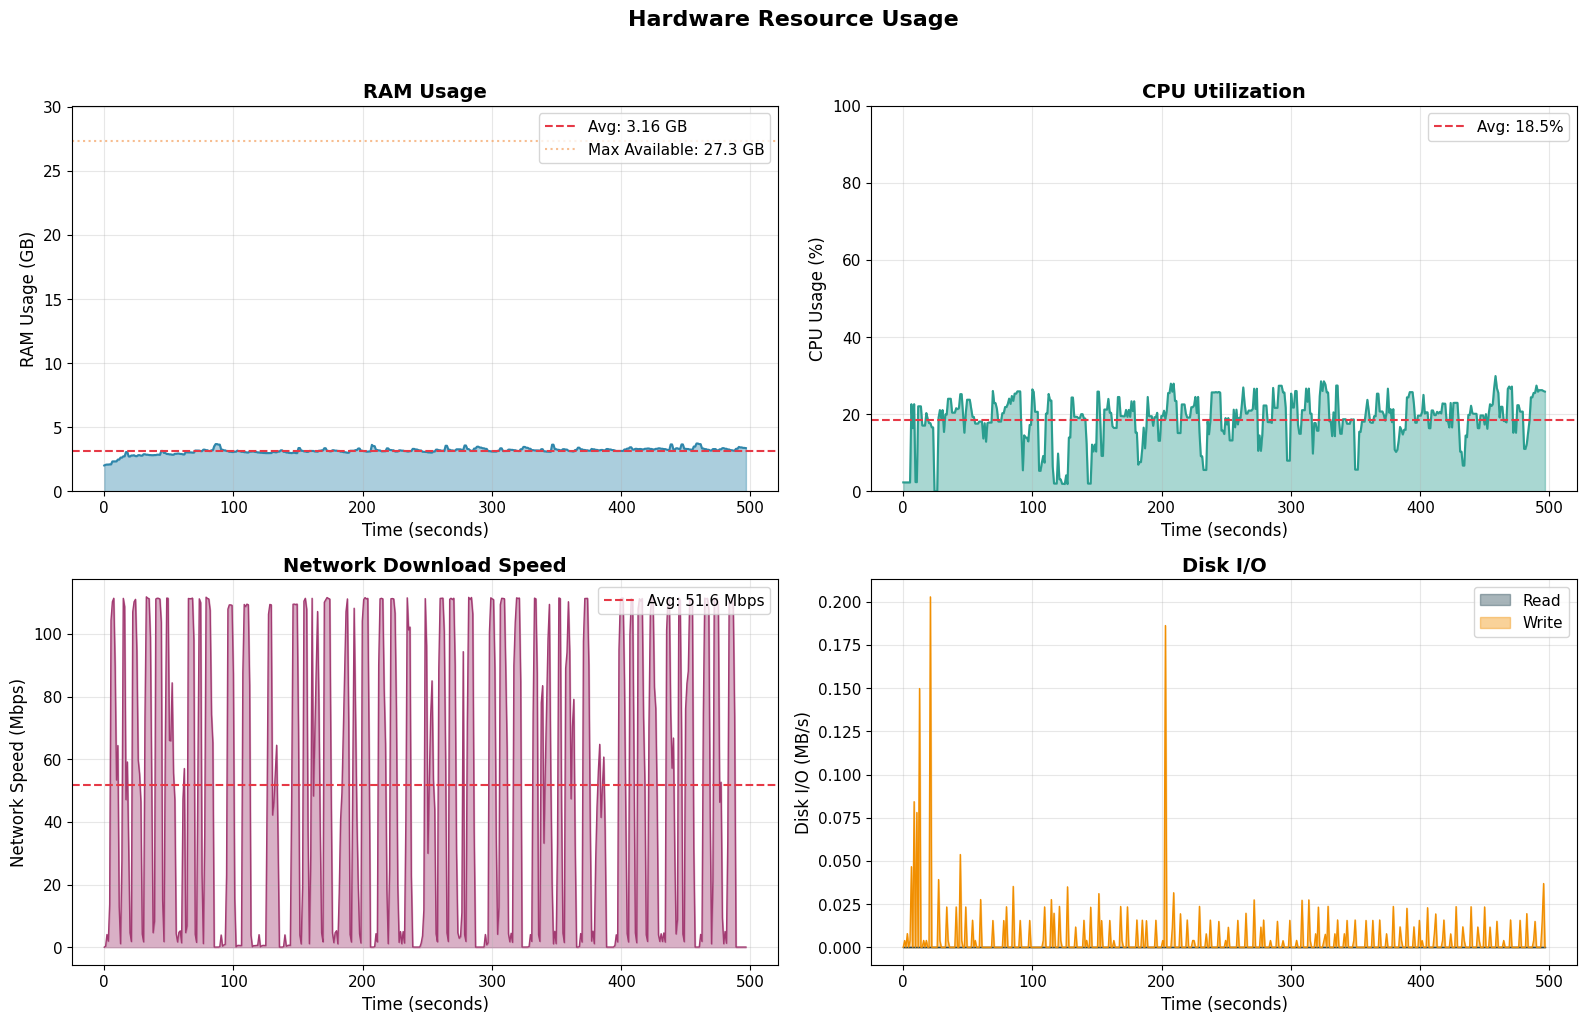


HARDWARE METRICS SUMMARY

 RAM:
   Min:  2.01 GB
   Max:  3.72 GB
   Avg:  3.16 GB
   Total: 27.3 GB

 CPU:
   Min:  0.0%
   Max:  29.9%
   Avg:  18.5%

 Network:
   Downloaded: 3055.3 MB
   Avg Speed:  51.6 Mbps
   Peak Speed: 111.8 Mbps

 Disk:
   Read:    0.0 MB
   Written: 2.5 MB


In [ ]:
if test_data['monitoring']:
    mon = test_data['monitoring']
    samples = pd.DataFrame(mon['samples'])
    samples['elapsed_seconds'] = samples['time'] - samples['time'].iloc[0]
    
    # Calculate derived metrics
    samples['mem_gb'] = samples['mem'] / (1024**3)
    samples['maxmem_gb'] = samples['maxmem'] / (1024**3)
    samples['netin_rate'] = samples['netin'].diff() / samples['time'].diff()
    samples['netin_mbps'] = samples['netin_rate'] * 8 / 1e6
    samples['diskread_rate'] = samples['diskread'].diff() / samples['time'].diff() / 1e6
    samples['diskwrite_rate'] = samples['diskwrite'].diff() / samples['time'].diff() / 1e6
    samples = samples.fillna(0)
    
    # Create 2x2 hardware metrics dashboard
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # RAM Usage
    ax1 = axes[0, 0]
    ax1.fill_between(samples['elapsed_seconds'], samples['mem_gb'], alpha=0.4, color=COLORS['ram'])
    ax1.plot(samples['elapsed_seconds'], samples['mem_gb'], color=COLORS['ram'], linewidth=1.5)
    ax1.axhline(y=samples['mem_gb'].mean(), color=COLORS['avg_line'], linestyle='--', 
                label=f"Avg: {samples['mem_gb'].mean():.2f} GB")
    ax1.axhline(y=samples['maxmem_gb'].iloc[0], color=COLORS['max_line'], linestyle=':', alpha=0.7,
                label=f"Max Available: {samples['maxmem_gb'].iloc[0]:.1f} GB")
    ax1.set_ylabel('RAM Usage (GB)', fontsize=12)
    ax1.set_xlabel('Time (seconds)', fontsize=12)
    ax1.set_title('RAM Usage', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, samples['maxmem_gb'].iloc[0] * 1.1)
    
    # CPU %
    ax2 = axes[0, 1]
    ax2.fill_between(samples['elapsed_seconds'], samples['cpu_percent'], alpha=0.4, color=COLORS['cpu'])
    ax2.plot(samples['elapsed_seconds'], samples['cpu_percent'], color=COLORS['cpu'], linewidth=1.5)
    ax2.axhline(y=mon['cpu_stats']['avg_percent'], color=COLORS['avg_line'], linestyle='--',
                label=f"Avg: {mon['cpu_stats']['avg_percent']:.1f}%")
    ax2.set_ylabel('CPU Usage (%)', fontsize=12)
    ax2.set_xlabel('Time (seconds)', fontsize=12)
    ax2.set_title('CPU Utilization', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, max(100, samples['cpu_percent'].max() * 1.1))
    
    # Network
    ax3 = axes[1, 0]
    ax3.fill_between(samples['elapsed_seconds'], samples['netin_mbps'], alpha=0.4, color=COLORS['network'])
    ax3.plot(samples['elapsed_seconds'], samples['netin_mbps'], color=COLORS['network'], linewidth=1)
    ax3.axhline(y=mon['network_transfer']['avg_speed_mbps_in'], color=COLORS['avg_line'], linestyle='--',
                label=f"Avg: {mon['network_transfer']['avg_speed_mbps_in']:.1f} Mbps")
    ax3.set_ylabel('Network Speed (Mbps)', fontsize=12)
    ax3.set_xlabel('Time (seconds)', fontsize=12)
    ax3.set_title('Network Download Speed', fontsize=14, fontweight='bold')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    # Disk I/O
    ax4 = axes[1, 1]
    ax4.fill_between(samples['elapsed_seconds'], samples['diskread_rate'], alpha=0.4, color=COLORS['disk_read'], label='Read')
    ax4.fill_between(samples['elapsed_seconds'], samples['diskwrite_rate'], alpha=0.4, color=COLORS['disk_write'], label='Write')
    ax4.plot(samples['elapsed_seconds'], samples['diskread_rate'], color=COLORS['disk_read'], linewidth=1)
    ax4.plot(samples['elapsed_seconds'], samples['diskwrite_rate'], color=COLORS['disk_write'], linewidth=1)
    ax4.set_ylabel('Disk I/O (MB/s)', fontsize=12)
    ax4.set_xlabel('Time (seconds)', fontsize=12)
    ax4.set_title('Disk I/O', fontsize=14, fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Hardware Resource Usage', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "=" * 60)
    print("HARDWARE METRICS SUMMARY")
    print("=" * 60)
    print(f"\n RAM:")
    print(f"   Min:  {samples['mem_gb'].min():.2f} GB")
    print(f"   Max:  {samples['mem_gb'].max():.2f} GB")
    print(f"   Avg:  {samples['mem_gb'].mean():.2f} GB")
    print(f"   Total: {samples['maxmem_gb'].iloc[0]:.1f} GB")
    
    print(f"\n CPU:")
    print(f"   Min:  {mon['cpu_stats']['min_percent']:.1f}%")
    print(f"   Max:  {mon['cpu_stats']['max_percent']:.1f}%")
    print(f"   Avg:  {mon['cpu_stats']['avg_percent']:.1f}%")
    
    print(f"\n Network:")
    print(f"   Downloaded: {mon['network_transfer']['mb_in']:.1f} MB")
    print(f"   Avg Speed:  {mon['network_transfer']['avg_speed_mbps_in']:.1f} Mbps")
    print(f"   Peak Speed: {samples['netin_mbps'].max():.1f} Mbps")
    
    print(f"\n Disk:")
    print(f"   Read:    {mon['disk_io']['mb_read']:.1f} MB")
    print(f"   Written: {mon['disk_io']['mb_written']:.1f} MB")
else:
    print("❌ No monitoring data available. Run with --proxmox flag to collect hardware metrics.")

### 5.4 Summary Report

This final subsection aggregates the key performance indicators across all grid sizes into a unified **2×2 chart** and a **summary table**.

The four charts highlight the metrics most relevant for choosing an optimal grid resolution:

| Chart | Insight |
|-------|---------|
| **Processing Time per km²** | Normalizes total time by the area each cell covers. Smaller cells incur higher per-km² overhead due to repeated STAC queries and Zarr chunk loading. |
| **Average Processing Time per Cell** | Absolute cost of processing a single cell. Grows with cell size because more data must be fetched and processed. |
| **Total Glacier Area Processing Time** | End-to-end execution time to cover the full glacier region. Balances per-cell overhead against the number of cells. |
| **Null Rate (Data Quality)** | Fraction of processed cells that yielded no valid snow percentage (e.g., due to full cloud masking). Color-coded to quickly flag problematic grid sizes. |

The accompanying table provides the exact numbers for each metric, making it straightforward to identify the grid size that offers the best trade-off between processing efficiency, spatial precision, and data quality.

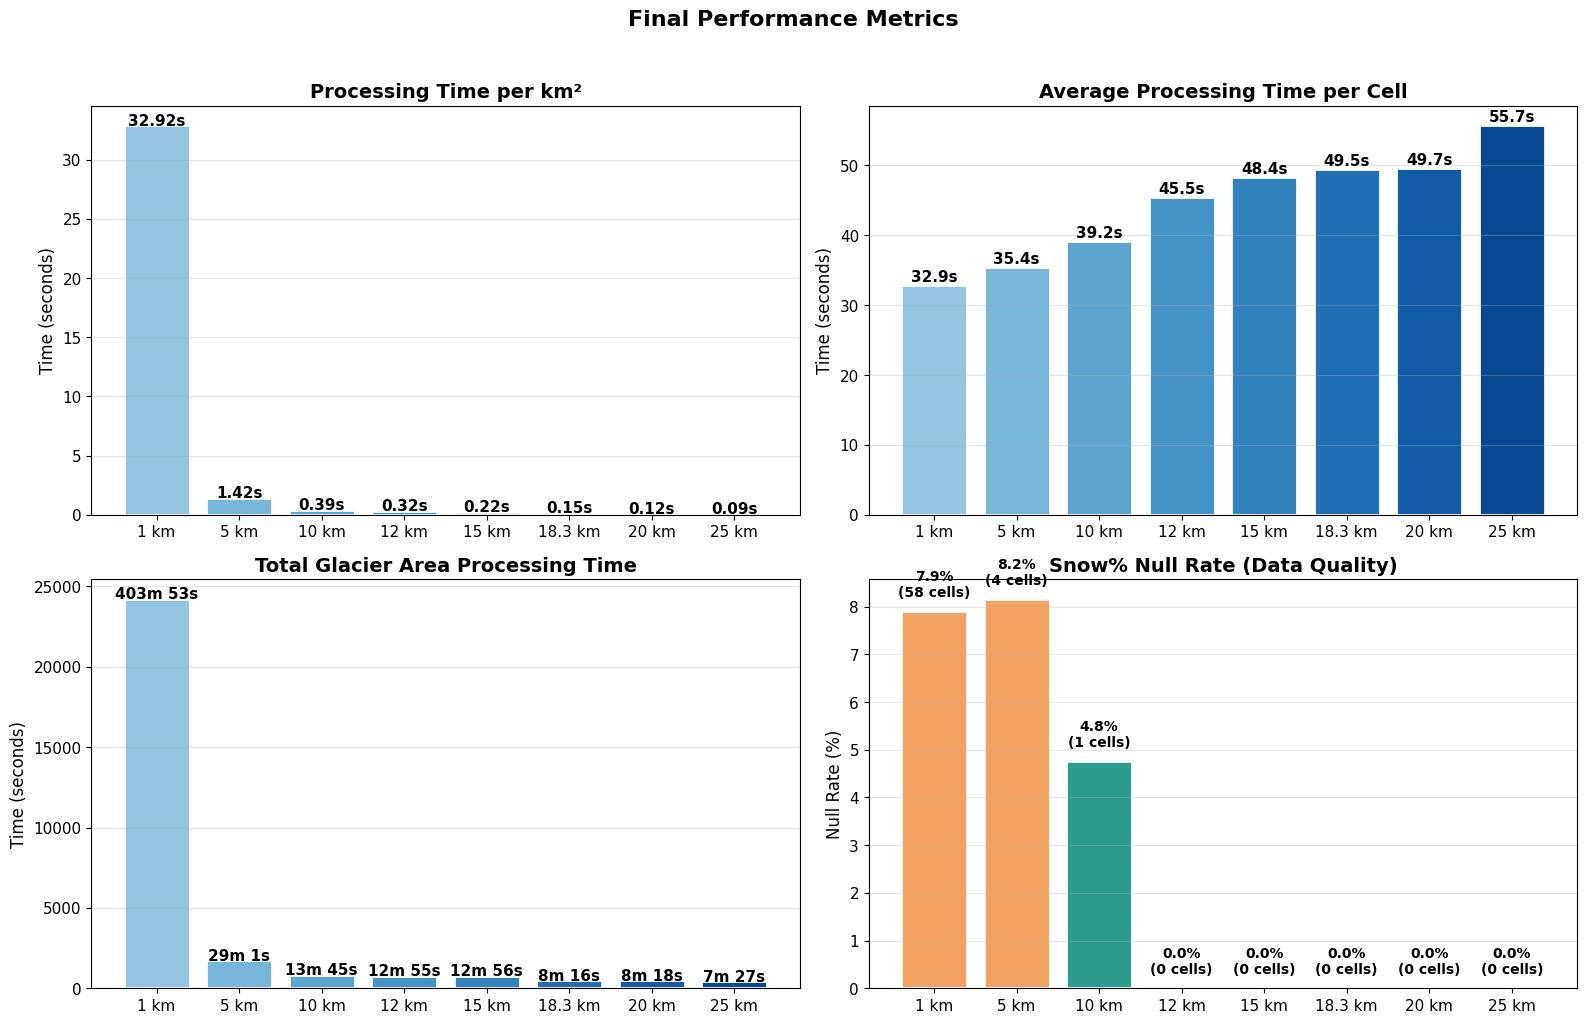


FINAL PERFORMANCE METRICS


Grid Size  Time per km² (s)  Avg Time per Cell (s)  \
0      1 km         32.917000                 32.917   
1      5 km          1.417080                 35.427   
2     10 km          0.391890                 39.189   
3     12 km          0.315757                 45.469   
4     15 km          0.215071                 48.391   
5   18.3 km          0.147890                 49.527   
6     20 km          0.124202                 49.681   
7     25 km          0.089184                 55.740   

   Total Processing Time (s)  Glacier Area (km²)  Cells Processed  Null Count  \
0                   24233.74            483.6250              675          58   
1                    1741.41            497.9972               45           4   
2                     825.44            503.5541               20           1   
3                     775.00            507.6755               17           0   
4                     776.23            513.5569               16           0   
5                     496.56            522.9388               10           0   
6                     498.22            510.5283               10           0   
7                     447.10            532.5562                8           0   

   Null Rate (%)  
0       7.912688  
1       8.163265  
2       4.761905  
3       0.000000  
4       0.000000  
5       0.000000  
6       0.000000  
7       0.000000

In [ ]:
# Calculate final metrics from all available tests
final_metrics = []

for size_km, data in sorted(cell_size_data.items()):
    if data['statistics']:
        stats = data['statistics']
        results = stats.get('results', {})
        timing = results.get('cell_timing', {})
        
        total_time = results.get('processing_time_seconds', 0)
        cells = results.get('total_cells_processed', 0)
        coverage_km2 = results.get('snow_ice_coverage_km2', 0)
        valid_area_km2 = results.get('total_valid_area_km2', 0)
        
        # Calculate metrics
        time_per_cell = timing.get('average_times_per_cell', {}).get('total_seconds', 
                                   total_time / cells if cells > 0 else 0)
        # Theoretical time per km²: project cell processing time to 1 km² basis
        # A cell of size_km x size_km covers size_km² area
        cell_area_km2 = size_km * size_km
        time_per_km2 = time_per_cell / cell_area_km2 if cell_area_km2 > 0 else 0
        
        # Calculate null rate from grid
        null_rate = 0.0
        null_count = 0
        total_processed = 0
        if data['grid'] is not None:
            grid = data['grid']
            processed = grid[grid['is_processed'] == True]
            total_processed = len(processed)
            if total_processed > 0 and 'snow_percentage' in processed.columns:
                null_count = int(processed['snow_percentage'].isna().sum())
                null_rate = 100 * null_count / total_processed
        
        final_metrics.append({
            'Grid Size': f'{size_km} km',
            'Grid Size (km)': size_km,
            'Time per km² (s)': time_per_km2,
            'Avg Time per Cell (s)': time_per_cell,
            'Total Processing Time (s)': total_time,
            'Glacier Area (km²)': coverage_km2,
            'Cells Processed': cells,
            'Null Count': null_count,
            'Null Rate (%)': null_rate
        })

if final_metrics:
    metrics_df = pd.DataFrame(final_metrics)
    
    # Create bar charts
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    sizes = metrics_df['Grid Size'].values
    colors = get_bar_colors(len(sizes))
    
    # Time per km²
    ax1 = axes[0, 0]
    bars1 = ax1.bar(sizes, metrics_df['Time per km² (s)'], color=colors, edgecolor='white', linewidth=2)
    ax1.set_ylabel('Time (seconds)', fontsize=12)
    ax1.set_title('Processing Time per km²', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars1, metrics_df['Time per km² (s)']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.2f}s', ha='center', fontsize=11, fontweight='bold')
    
    # Avg Time per Cell
    ax2 = axes[0, 1]
    bars2 = ax2.bar(sizes, metrics_df['Avg Time per Cell (s)'], color=colors, edgecolor='white', linewidth=2)
    ax2.set_ylabel('Time (seconds)', fontsize=12)
    ax2.set_title('Average Processing Time per Cell', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars2, metrics_df['Avg Time per Cell (s)']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.1f}s', ha='center', fontsize=11, fontweight='bold')
    
    # Total Processing Time for Glacier Area
    ax3 = axes[1, 0]
    bars3 = ax3.bar(sizes, metrics_df['Total Processing Time (s)'], color=colors, edgecolor='white', linewidth=2)
    ax3.set_ylabel('Time (seconds)', fontsize=12)
    ax3.set_title('Total Glacier Area Processing Time', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars3, metrics_df['Total Processing Time (s)']):
        mins = int(val // 60)
        secs = int(val % 60)
        label = f'{mins}m {secs}s' if mins > 0 else f'{val:.0f}s'
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                label, ha='center', fontsize=11, fontweight='bold')
    
    # Null Rate (Data Quality)
    ax4 = axes[1, 1]
    null_colors = [COLORS['critical'] if v > 10 else COLORS['warning'] if v > 5 else COLORS['good'] for v in metrics_df['Null Rate (%)']]
    bars4 = ax4.bar(sizes, metrics_df['Null Rate (%)'], color=null_colors, edgecolor='white', linewidth=2)
    ax4.set_ylabel('Null Rate (%)', fontsize=12)
    ax4.set_title('Snow% Null Rate (Data Quality)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    for bar, val, cnt in zip(bars4, metrics_df['Null Rate (%)'], metrics_df['Null Count']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                f'{val:.1f}%\n({int(cnt)} cells)', ha='center', fontsize=10, fontweight='bold')
    
    plt.suptitle('Final Performance Metrics', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n" + "=" * 80)
    print("FINAL PERFORMANCE METRICS")
    print("=" * 80)
    display(metrics_df[['Grid Size', 'Time per km² (s)', 'Avg Time per Cell (s)', 
                        'Total Processing Time (s)', 'Glacier Area (km²)', 'Cells Processed',
                        'Null Count', 'Null Rate (%)']])
else:
    print("❌ No statistics data available for final metrics.")